      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
mean       8.311111          0.531339     0.268364        2.532152   0.086933   
std        1.747595          0.179633     0.196686        1.355917   0.047267   
min        4.600000          0.120000     0.000000        0.900000   0.012000   
max       15.900000          1.580000     1.000000       15.500000   0.611000   

      free sulfur dioxide  total sulfur dioxide   density        pH  \
mean            15.615486             45.914698  0.996730  3.311015   
std             10.250486             32.782130  0.001925  0.156664   
min              1.000000              6.000000  0.990070  2.740000   
max             68.000000            289.000000  1.003690  4.010000   

      sulphates    alcohol   quality  
mean   0.657708  10.442111  5.657043  
std    0.170399   1.082196  0.805824  
min    0.330000   8.400000  3.000000  
max    2.000000  14.900000  8.000000  


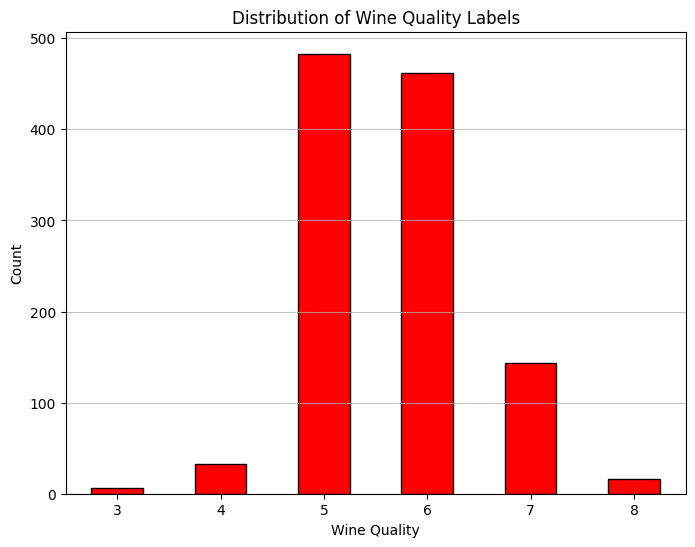

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

#-------Load the dataset and Print the statistics-------------
wine_data = pd.read_csv("../../data/external/WineQT.csv")

wine_data = wine_data.drop(columns=['Id'])
statistics = wine_data.agg(['mean', 'std', 'min', 'max'])
print(statistics)

#---a graph that shows the distribution of the various labels across the entire dataset----
wine_quality = wine_data['quality']

plt.figure(figsize=(8, 6))
wine_quality.value_counts().sort_index().plot(kind='bar', color='red', edgecolor='black')
plt.xlabel('Wine Quality')
plt.ylabel('Count')
plt.title('Distribution of Wine Quality Labels')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.75)
plt.show()

#---------Split the data into train (70%), validation (15%), and test (15%) sets--------
X = wine_data.drop(columns=['quality'])
y = wine_data['quality']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#-------------------Normalise and standarize the data------------------
# Handle missing data (if any)
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)
X_test = imputer.transform(X_test)

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_val_normalized = scaler.transform(X_val)
X_test_normalized = scaler.transform(X_test)

# Standardize the data (mean=0, std=1) using Z-score scaling
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_val_standardized = scaler.transform(X_val)
X_test_standardized = scaler.transform(X_test)

Og

MOD

In [3]:
import numpy as np

class MLPClassifier:
    def __init__(self, num_hidden_layers=1, num_neurons=64, activation='relu', learning_rate=0.01, num_classes=6):
        self.num_hidden_layers = num_hidden_layers
        self.num_neurons = num_neurons
        self.activation = activation
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.weights = []
        self.biases = []
        self.activations = [self.activation] * (num_hidden_layers + 1)
        self.activations[-1] = 'softmax'

    def initialize_weights_and_biases(self, input_dim):
        layer_sizes = [input_dim] + [self.num_neurons] * self.num_hidden_layers + [self.num_classes]
        self.weights = []
        self.biases = []
        for i in range(1, len(layer_sizes)):
            input_size, output_size = layer_sizes[i - 1], layer_sizes[i]
            weight = np.random.randn(input_size, output_size) * 0.01
            bias = np.zeros((1, output_size))
            self.weights.append(weight)
            self.biases.append(bias)

    def one_hot_encode(self, y):
        one_hot = np.zeros((len(y), self.num_classes))
        one_hot[np.arange(len(y)), y - 3] = 1
        return one_hot

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / exp_x.sum(axis=1, keepdims=True)

    def compute_loss(self, y_true, y_pred):
        m = len(y_true)
        loss = -1/m * np.sum(y_true * np.log(y_pred + 1e-8))
        return loss

    def activate(self, x, activation_type):
        if activation_type == 'relu':
            return np.maximum(0, x)
        elif activation_type == 'sigmoid':
            x = np.clip(x, -500, 500)
            return 1 / (1 + np.exp(-x))
        elif activation_type == 'tanh':
            return np.tanh(x)
        elif activation_type == 'softmax':
            return self.softmax(x)

    def d_relu(self, x):
        return np.where(x > 0, 1, 0)

    def d_sigmoid(self, x):
        return x * (1 - x)

    def d_tanh(self, x):
        return 1 - np.tanh(x) ** 2

    def forward_propagation(self, x):
        z_values = []
        a_values = [x]
        for i in range(self.num_hidden_layers):
            z = np.dot(a_values[i], self.weights[i]) + self.biases[i]
            a = self.activate(z, self.activations[i])
            z_values.append(z)
            a_values.append(a)

        # Output layer with softmax activation
        z = np.dot(a_values[-1], self.weights[-1]) + self.biases[-1]
        a = self.activate(z, self.activations[-1])
        z_values.append(z)
        a_values.append(a)

        return z_values, a_values

    def backward_propagation(self, x, y):
        m = x.shape[0]
        z_values, a_values = self.forward_propagation(x)
        gradients = [None] * (self.num_hidden_layers + 1)

        # Compute gradient of the output layer
        gradients[-1] = a_values[-1] - y

        # Backpropagate through hidden layers
        for i in reversed(range(self.num_hidden_layers)):
            if self.activations[i] == 'relu':
                gradients[i] = np.dot(gradients[i + 1], self.weights[i + 1].T) * self.d_relu(a_values[i + 1])
            elif self.activations[i] == 'sigmoid':
                gradients[i] = np.dot(gradients[i + 1], self.weights[i + 1].T) * self.d_sigmoid(a_values[i + 1])
            elif self.activations[i] == 'tanh':
                gradients[i] = np.dot(gradients[i + 1], self.weights[i + 1].T) * self.d_tanh(a_values[i + 1])

        # Compute gradients for weights and biases
        dW = [None] * (self.num_hidden_layers + 1)
        db = [None] * (self.num_hidden_layers + 1)
        for i in range(self.num_hidden_layers + 1):
            dW[i] = np.dot(a_values[i].T, gradients[i]) / m
            db[i] = np.sum(gradients[i], axis=0) / m

        return dW, db

    def update_parameters(self, dW, db):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * dW[i]
            self.biases[i] -= self.learning_rate * db[i]

    def predict(self, x):
        _, y_pred = self.forward_propagation(x)
        shifted_y_pred = np.argmax(y_pred[-1], axis=1) + 3
        return shifted_y_pred

    def fit(self, X_train, y_train, X_val, y_val, optimizer='sgd', batch_size=32, num_epochs=1000):
        # Initialize weights and biases
        input_dim = X_train.shape[1]
        self.initialize_weights_and_biases(input_dim)
        y_encoded = self.one_hot_encode(y_train)
        y_val_encoded = self.one_hot_encode(y_val)

        # Training loop
        for epoch in range(num_epochs):
            if optimizer == 'sgd':
                for i in range(X_train.shape[0]):
                    x_sample = X_train[i:i+1]
                    y_sample = y_encoded[i:i+1]
                    dW, db = self.backward_propagation(x_sample, y_sample)
                    self.update_parameters(dW, db)
            elif optimizer == 'mini_batch':
                for i in range(0, X_train.shape[0], batch_size):
                    x_batch = X_train[i:i+batch_size]
                    y_batch = y_encoded[i:i+batch_size]
                    dW, db = self.backward_propagation(x_batch, y_batch)
                    self.update_parameters(dW, db)

            # Evaluate on validation set
            val_accuracy = self.evaluate_model(X_val, y_val, isTrain=False)
            wandb.log({"Validation Accuracy": val_accuracy})

            if (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch + 1}/{num_epochs}, Validation Accuracy: {val_accuracy:.4f}")

        print("Training complete!")

    def evaluate_model(self, x, y, isTrain=True):
        _, y_pred = self.forward_propagation(x)
        shifted_y_pred = np.argmax(y_pred[-1], axis=1) + 3
        accuracy = np.mean(shifted_y_pred == y)
        if isTrain:
            wandb.log({f"Train Accuracy": accuracy})
            print("Train Accuracy: {}".format(accuracy))
        else:
            wandb.log({f"Validation Accuracy": accuracy})
            print("Validation Accuracy : {}".format(accuracy))
       
        return accuracy

    def gradient_check(self, x, y, epsilon=1e-7):
        # Perform forward propagation to compute the predicted values and loss
        input_dim = x.shape[1]
        self.initialize_weights_and_biases(input_dim)
        y_encoded = self.one_hot_encode(y)
        
        # Get gradients from backpropagation
        dW, db = self.backward_propagation(x, y_encoded)
        
        # Perform numerical gradient checking
        for layer in range(len(self.weights)):
            # Check weights
            weight_grad_approx = np.zeros(self.weights[layer].shape)
            for i in range(self.weights[layer].shape[0]):
                for j in range(self.weights[layer].shape[1]):
                    theta_plus = np.copy(self.weights[layer])
                    theta_minus = np.copy(self.weights[layer])
                    
                    theta_plus[i, j] += epsilon
                    theta_minus[i, j] -= epsilon
                    
                    self.weights[layer] = theta_plus
                    _, y_pred_plus = self.forward_propagation(x)
                    loss_plus = self.compute_loss(y_encoded, y_pred_plus[-1])
                    
                    self.weights[layer] = theta_minus
                    _, y_pred_minus = self.forward_propagation(x)
                    loss_minus = self.compute_loss(y_encoded, y_pred_minus[-1])
                    
                    weight_grad_approx[i, j] = (loss_plus - loss_minus) / (2 * epsilon)
                    
            diff_weights = np.linalg.norm(dW[layer] - weight_grad_approx) / (np.linalg.norm(dW[layer]) + np.linalg.norm(weight_grad_approx))
            print(f"Layer {layer+1} Weights Gradient Check difference: {diff_weights}")
            
            # Check biases
            bias_grad_approx = np.zeros(self.biases[layer].shape)
            for i in range(self.biases[layer].shape[1]):
                theta_plus = np.copy(self.biases[layer])
                theta_minus = np.copy(self.biases[layer])
                
                theta_plus[0, i] += epsilon
                theta_minus[0, i] -= epsilon
                
                self.biases[layer] = theta_plus
                _, y_pred_plus = self.forward_propagation(x)
                loss_plus = self.compute_loss(y_encoded, y_pred_plus[-1])
                
                self.biases[layer] = theta_minus
                _, y_pred_minus = self.forward_propagation(x)
                loss_minus = self.compute_loss(y_encoded, y_pred_minus[-1])
                
                bias_grad_approx[0, i] = (loss_plus - loss_minus) / (2 * epsilon)
                
            diff_biases = np.linalg.norm(db[layer] - bias_grad_approx) / (np.linalg.norm(db[layer]) + np.linalg.norm(bias_grad_approx))
            print(f"Layer {layer+1} Biases Gradient Check difference: {diff_biases}")

# Initialize your MLPClassifier
mlp = MLPClassifier(num_hidden_layers=2, num_neurons=64, activation='relu', learning_rate=0.01, num_classes=6)

# Assuming X_train and y_train are your training data
x_sample = X_train[:5]  # Select a small subset of your data
y_sample = y_train[:5]  # Corresponding labels

# Perform gradient checking
mlp.gradient_check(x_sample, y_sample)


Layer 1 Weights Gradient Check difference: 6.754758146999727e-08
Layer 1 Biases Gradient Check difference: 1.679588570536197e-06
Layer 2 Weights Gradient Check difference: 8.26550409444272e-06
Layer 2 Biases Gradient Check difference: 1.0984595657000771e-07
Layer 3 Weights Gradient Check difference: 3.4342775506166016e-05
Layer 3 Biases Gradient Check difference: 5.1198880905193474e-08


### FINAL CODES


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from itertools import product

def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    
    # 1. Describe the dataset
    print(data.describe())
    
    # 2. Plot distribution of quality labels
    plt.figure(figsize=(10, 6))
    sns.countplot(x='quality', data=data)
    plt.title('Distribution of Wine Quality')
    plt.show()
    
    # 3. Normalize and standardize data
    X = data.drop('quality', axis=1)
    y = data['quality']
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # One-hot encode the target variable
    y_encoded = pd.get_dummies(y).values
    
    return X_scaled, y_encoded



In [28]:

class ActivationFunction:
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-np.clip(x, -709, 709)))

    @staticmethod
    def sigmoid_derivative(x):
        return x * (1 - x)

    @staticmethod
    def tanh(x):
        return np.tanh(x)

    @staticmethod
    def tanh_derivative(x):
        return 1 - np.tanh(x)**2

    @staticmethod
    def relu(x):
        return np.maximum(0, x)

    @staticmethod
    def relu_derivative(x):
        return np.where(x > 0, 1, 0)

    @staticmethod
    def linear(x):
        return x

    @staticmethod
    def linear_derivative(x):
        return np.ones_like(x)

    @staticmethod
    def softmax(x):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / np.sum(e_x, axis=1, keepdims=True)

class MLPClassifier:
    def __init__(self, input_size, hidden_sizes, output_size, activation='relu', 
                 learning_rate=0.01, epochs=100, batch_size=32, optimizer='sgd', patience=5, min_delta=0.001):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.patience = patience
        self.min_delta = min_delta

        self.weights = []
        self.biases = []
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(1, len(layer_sizes)):
            self.weights.append(np.random.randn(layer_sizes[i-1], layer_sizes[i]) * np.sqrt(2. / layer_sizes[i-1]))
            self.biases.append(np.zeros((1, layer_sizes[i])))

        self.set_activation(activation)

    def set_activation(self, activation):
        if activation == 'sigmoid':
            self.activation = ActivationFunction.sigmoid
            self.activation_derivative = ActivationFunction.sigmoid_derivative
        elif activation == 'tanh':
            self.activation = ActivationFunction.tanh
            self.activation_derivative = ActivationFunction.tanh_derivative
        elif activation == 'relu':
            self.activation = ActivationFunction.relu
            self.activation_derivative = ActivationFunction.relu_derivative
        elif activation == 'linear':
            self.activation = ActivationFunction.linear
            self.activation_derivative = ActivationFunction.linear_derivative
        else:
            raise ValueError("Unsupported activation function")

    def forward_propagation(self, X):
        self.layer_outputs = [X]
        for i in range(len(self.weights)):
            z = np.dot(self.layer_outputs[-1], self.weights[i]) + self.biases[i]
            a = self.activation(z) if i < len(self.weights) - 1 else ActivationFunction.softmax(z)
            self.layer_outputs.append(a)
        return self.layer_outputs[-1]

    def backward_propagation(self, X, y):
        m = X.shape[0]
        delta = self.layer_outputs[-1] - y
        gradients = []
        for i in reversed(range(len(self.weights))):
            dW = np.dot(self.layer_outputs[i].T, delta) / m
            db = np.sum(delta, axis=0, keepdims=True) / m
            gradients.append((dW, db))
            if i > 0:
                delta = np.dot(delta, self.weights[i].T) * self.activation_derivative(self.layer_outputs[i])
        return list(reversed(gradients))

    def update_parameters(self, gradients):
        for i, (dW, db) in enumerate(gradients):
            self.weights[i] -= self.learning_rate * dW
            self.biases[i] -= self.learning_rate * db

    def fit(self, X, y, X_val=None, y_val=None):
        self.losses = []
        self.val_losses = []
        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(self.epochs):
            for i in range(0, X.shape[0], self.batch_size):
                batch_X = X[i:i+self.batch_size]
                batch_y = y[i:i+self.batch_size]
                
                y_pred = self.forward_propagation(batch_X)
                gradients = self.backward_propagation(batch_X, batch_y)
                self.update_parameters(gradients)
            
            loss = self.compute_loss(X, y)
            self.losses.append(loss)
            
            if X_val is not None and y_val is not None:
                val_loss = self.compute_loss(X_val, y_val)
                self.val_losses.append(val_loss)
                
                if val_loss < best_val_loss - self.min_delta:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= self.patience:
                    # print(f"Early stopping at epoch {epoch}")
                    break
            
            # if (epoch + 1) % 100 == 0:
                # print(f"Epoch {epoch + 1}/{self.epochs}, Loss: {loss:.4f}")

    def predict(self, X):
        return np.argmax(self.forward_propagation(X), axis=1)

    def compute_loss(self, X, y):
        y_pred = self.forward_propagation(X)
        return -np.mean(y * np.log(y_pred + 1e-8))

    def gradient_checking(self, X, y, epsilon=1e-7):
        gradients = self.backward_propagation(X, y)
        for i, (dW, db) in enumerate(gradients):
            for j in range(dW.shape[0]):
                for k in range(dW.shape[1]):
                    self.weights[i][j, k] += epsilon
                    cost_plus = self.compute_loss(X, y)
                    self.weights[i][j, k] -= 2 * epsilon
                    cost_minus = self.compute_loss(X, y)
                    self.weights[i][j, k] += epsilon
                    
                    grad_approx = (cost_plus - cost_minus) / (2 * epsilon)
                    grad_backprop = dW[j, k]
                    
                    rel_error = abs(grad_backprop - grad_approx) / max(abs(grad_backprop), abs(grad_approx))
                    if rel_error > 1e-5:
                        print(f"Gradient Check Failed for W[{i}][{j},{k}]. Relative Error: {rel_error:.6f}")
                        return False
        
        print("Gradient Check Passed!")
        return True

In [21]:
# import wandb
# from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, config):
#     model = MLPClassifier(
#         input_size=X_train.shape[1],
#         hidden_sizes=config['hidden_sizes'],
#         output_size=y_train.shape[1],
#         activation=config['activation'],
#         learning_rate=config['learning_rate'],
#         epochs=config['epochs'],
#         batch_size=config['batch_size'],
#         optimizer=config['optimizer']
#     )
    
#     model.fit(X_train, y_train, X_val, y_val)
    
#     y_pred = model.predict(X_test)
#     y_true = np.argmax(y_test, axis=1)
    
#     accuracy = accuracy_score(y_true, y_pred)
#     f1 = f1_score(y_true, y_pred, average='weighted')
#     precision = precision_score(y_true, y_pred, average='weighted')
#     recall = recall_score(y_true, y_pred, average='weighted')
    
#     return model, accuracy, f1, precision, recall

# def hyperparameter_tuning(X_train, y_train, X_val, y_val, X_test, y_test):
#     # Define hyperparameters to tune
#     hidden_sizes_list = [[64, 32], [128, 64], [256, 128]]
#     activations = ['sigmoid', 'tanh', 'relu']
#     learning_rates = [0.0001, 0.001, 0.01]
#     epochs_list = [100, 500, 1000]
#     batch_sizes = [16, 32, 64]
#     optimizers = ['sgd', 'batch', 'mini-batch']

#     best_model = None
#     best_accuracy = 0
#     best_config = None

#     wandb.init(project='q2_test_1', entity='vishnuvarun-iiit-hyderabad')

#     for hidden_sizes, activation, lr, epochs, batch_size, optimizer in product(hidden_sizes_list, activations, learning_rates, epochs_list, batch_sizes, optimizers):
#         config = {
#             'hidden_sizes': hidden_sizes,
#             'activation': activation,
#             'learning_rate': lr,
#             'epochs': epochs,
#             'batch_size': batch_size,
#             'optimizer': optimizer
#         }
        
#         print(f"Testing configuration: {config}")
        
#         model, accuracy, f1, precision, recall = train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, config)
        
#         wandb.log({
#             "accuracy": accuracy,
#             "f1_score": f1,
#             "precision": precision,
#             "recall": recall
#         })
        
#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             best_model = model
#             best_config = config

#     print("Best Model Configuration:")
#     print(best_config)
#     wandb.finish()
#     return best_model

import wandb
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from prettytable import PrettyTable
from itertools import product

def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, config):
    model = MLPClassifier(
        input_size=X_train.shape[1],
        hidden_sizes=config['hidden_sizes'],
        output_size=y_train.shape[1],
        activation=config['activation'],
        learning_rate=config['learning_rate'],
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        optimizer=config['optimizer']
    )
    
    model.fit(X_train, y_train, X_val, y_val)
    
    y_pred = model.predict(X_test)
    y_true = np.argmax(y_test, axis=1)
    
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    
    return model, accuracy, f1, precision, recall

def hyperparameter_tuning(X_train, y_train, X_val, y_val, X_test, y_test):
    # Define hyperparameters to tune
    hidden_sizes_list = [[64, 32], [128, 64], [256, 128]]
    activations = ['sigmoid', 'tanh', 'relu']
    learning_rates = [0.0001, 0.001, 0.01]
    epochs_list = [100, 500, 1000]
    batch_sizes = [16, 32, 64]
    optimizers = ['sgd', 'batch', 'mini-batch']

    best_model = None
    best_accuracy = 0
    best_config = None

    wandb.init(project='q2_1', entity='vishnuvarun-iiit-hyderabad')

    # Initialize PrettyTable
    metrics_table = PrettyTable()
    metrics_table.field_names = ["Hidden Sizes", "Activation", "Learning Rate", "Epochs", "Batch Size", "Optimizer", "Accuracy", "F1 Score", "Precision", "Recall"]

    for hidden_sizes, activation, lr, epochs, batch_size, optimizer in product(hidden_sizes_list, activations, learning_rates, epochs_list, batch_sizes, optimizers):
        config = {
            'hidden_sizes': hidden_sizes,
            'activation': activation,
            'learning_rate': lr,
            'epochs': epochs,
            'batch_size': batch_size,
            'optimizer': optimizer
        }
        
        print(f"Testing configuration: {config}")
        
        model, accuracy, f1, precision, recall = train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, config)
        
        wandb.log({
            "accuracy": accuracy,
            "f1_score": f1,
            "precision": precision,
            "recall": recall
        })
        
        # Add row to PrettyTable
        metrics_table.add_row([hidden_sizes, activation, lr, epochs, batch_size, optimizer, accuracy, f1, precision, recall])
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
            best_config = config

    print("Best Model Configuration:")
    print(best_config)
    
    # Print the table
    print(metrics_table)
    
    wandb.finish()
    return  best_model

In [20]:
def evaluate_best_model(X_test_standardized, y_test, X_val_standardized, y_val, best_model):
    print("Best Model Parameters:")
    print(f"Hidden Sizes: {best_model.hidden_sizes}")
    print(f"Activation Function: {best_model.activation}")
    print(f"Learning Rate: {best_model.learning_rate}")
    print(f"Optimizer: {best_model.optimizer}")
    print(f"Batch Size: {best_model.batch_size}")
    print(f"Number of Epochs: {best_model.epochs}")
    
    # Evaluate on validation set
    y_pred_val = best_model.predict(X_val_standardized)
    y_true_val = np.argmax(y_val, axis=1)
    
    val_accuracy = accuracy_score(y_true_val, y_pred_val)
    val_f1 = f1_score(y_true_val, y_pred_val, average='weighted')
    val_precision = precision_score(y_true_val, y_pred_val, average='weighted')
    val_recall = recall_score(y_true_val, y_pred_val, average='weighted')
    
    print("\nValidation Set Metrics:")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation F1 Score: {val_f1:.4f}")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    
    # Evaluate on test set
    y_pred_test = best_model.predict(X_test_standardized)
    y_true_test = np.argmax(y_test, axis=1)
    
    test_accuracy = accuracy_score(y_true_test, y_pred_test)
    test_f1 = f1_score(y_true_test, y_pred_test, average='weighted')
    test_precision = precision_score(y_true_test, y_pred_test, average='weighted')
    test_recall = recall_score(y_true_test, y_pred_test, average='weighted')
    
    print("\nTest Set Metrics:")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")

In [19]:
def analyze_hyperparameters(X_train, y_train, X_val, y_val):
    
    # Effect of Non-linearity
    activations = ['sigmoid', 'tanh', 'relu', 'linear']
    plt.figure(figsize=(12, 8))
    for activation in activations:
        model = MLPClassifier(input_size=X_train.shape[1], hidden_sizes=[128, 64], output_size=y_train.shape[1],
                              activation=activation, learning_rate=0.01, epochs=50, batch_size=64,optimizer='mini-batch')
        model.fit(X_train, y_train, X_val, y_val)
        plt.plot(model.val_losses, label=activation)
    plt.title('Effect of Activation Functions')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.show()
    
    # Effect of Learning Rate
    learning_rates = [0.0001, 0.001, 0.01, 0.1]
    plt.figure(figsize=(12, 8))
    for lr in learning_rates:
        model = MLPClassifier(input_size=X_train.shape[1], hidden_sizes=[128, 64], output_size=y_train.shape[1],
                              activation='tanh', learning_rate=lr, epochs=50, batch_size=64,optimizer='mini-batch')
        model.fit(X_train, y_train, X_val, y_val)
        plt.plot(model.val_losses, label=f'LR: {lr}')
    plt.title('Effect of Learning Rate')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.show()
    
    # Effect of Batch Size
    batch_sizes = [16, 32, 64, 128]
    plt.figure(figsize=(12, 8))
    for bs in batch_sizes:
        model = MLPClassifier(input_size=X_train.shape[1], hidden_sizes=[128, 64], output_size=y_train.shape[1],
                              activation='tanh', learning_rate=0.01, epochs=50, batch_size=bs, optimizer='mini-batch')
        model.fit(X_train, y_train, X_val, y_val)
        plt.plot(model.val_losses, label=f'Batch Size: {bs}')
    plt.title('Effect of Batch Size')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.show()
    
    
    
    


       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1143.000000       1143.000000  1143.000000     1143.000000   
mean        8.311111          0.531339     0.268364        2.532152   
std         1.747595          0.179633     0.196686        1.355917   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.392500     0.090000        1.900000   
50%         7.900000          0.520000     0.250000        2.200000   
75%         9.100000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1143.000000          1143.000000           1143.000000  1143.000000   
mean      0.086933            15.615486             45.914698     0.996730   
std       0.047267            10.250486             32.782130     0.001925   
min       0.012000             1.000000         

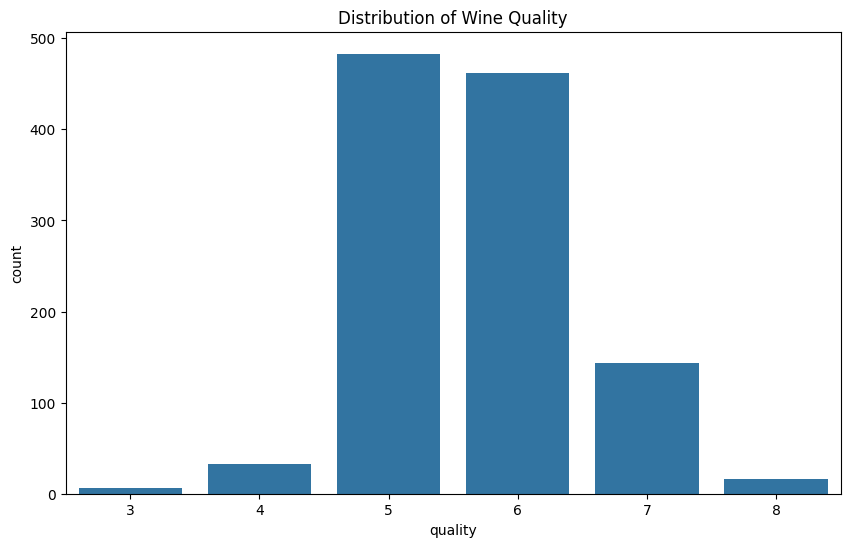

In [6]:
# Load and preprocess the data
file_path = '../../data/external/WineQT.csv'  # Update with the correct path to your dataset
X_scaled, y_encoded = load_and_preprocess_data(file_path)

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [9]:

# Define a configuration for the model
config = {
    'hidden_sizes': [64, 32],
    'activation': 'relu',
    'learning_rate': 0.01,
    'epochs': 100,
    'batch_size': 32,
    'optimizer': 'sgd'
}

# Train and evaluate the model
model, accuracy, f1, precision, recall = train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, config)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")




Early stopping at epoch 48
Accuracy: 0.6105
F1 Score: 0.5925
Precision: 0.5799
Recall: 0.6105


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [29]:

import wandb
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from prettytable import PrettyTable
from itertools import product

def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, config):
    model = MLPClassifier(
        input_size=X_train.shape[1],
        hidden_sizes=config['hidden_sizes'],
        output_size=y_train.shape[1],
        activation=config['activation'],
        learning_rate=config['learning_rate'],
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        optimizer=config['optimizer']
    )
    
    model.fit(X_train, y_train, X_val, y_val)
    
    y_pred = model.predict(X_test)
    y_true = np.argmax(y_test, axis=1)
    
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    
    return model, accuracy, f1, precision, recall

def hyperparameter_tuning(X_train, y_train, X_val, y_val, X_test, y_test):
    # Define hyperparameters to tune
    hidden_sizes_list = [[64, 32], [128, 64], [256, 128]]
    activations = ['sigmoid', 'tanh', 'relu']
    learning_rates = [0.0001, 0.001, 0.01]
    epochs_list = [100, 500, 1000]
    batch_sizes = [16, 32, 64]
    optimizers = ['sgd', 'batch', 'mini-batch']

    best_model = None
    best_accuracy = 0
    best_config = None

    wandb.init(project='q2_1', entity='vishnuvarun-iiit-hyderabad')

    # Initialize PrettyTable
    metrics_table = PrettyTable()
    metrics_table.field_names = ["Hidden Sizes", "Activation", "Learning Rate", "Epochs", "Batch Size", "Optimizer", "Accuracy", "F1 Score", "Precision", "Recall"]

    for hidden_sizes, activation, lr, epochs, batch_size, optimizer in product(hidden_sizes_list, activations, learning_rates, epochs_list, batch_sizes, optimizers):
        config = {
            'hidden_sizes': hidden_sizes,
            'activation': activation,
            'learning_rate': lr,
            'epochs': epochs,
            'batch_size': batch_size,
            'optimizer': optimizer
        }
        
        # print(f"Testing configuration: {config}")
        
        model, accuracy, f1, precision, recall = train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, config)
        
        wandb.log({
            "accuracy": accuracy,
            "f1_score": f1,
            "precision": precision,
            "recall": recall
        })
        
        # Add row to PrettyTable
        metrics_table.add_row([hidden_sizes, activation, lr, epochs, batch_size, optimizer, accuracy, f1, precision, recall])
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
            best_config = config

    print("Best Model Configuration:")
    print(best_config)
    
    # Print the table
    print(metrics_table)
    
    wandb.finish()
    return  best_model

In [10]:

# Perform hyperparameter tuning
best_model= hyperparameter_tuning(X_train, y_train, X_val, y_val, X_test, y_test)



wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: vishnuvarun (vishnuvarun-iiit-hyderabad). Use `wandb login --relogin` to force relogin


Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}
Epoch 100/100, Loss: 0.2320
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2437
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2269
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2809
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2331
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2625
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2659
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2878
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.3058
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2216
Early stopping at epoch 143
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2230
Early stopping at epoch 126
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 73
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2413
Early stopping at epoch 185
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2641
Epoch 200/500, Loss: 0.2286
Early stopping at epoch 248
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2768
Epoch 200/500, Loss: 0.2388
Early stopping at epoch 216
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2992
Epoch 200/500, Loss: 0.2635
Early stopping at epoch 294
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.3440
Epoch 200/500, Loss: 0.2903
Epoch 300/500, Loss: 0.2572
Early stopping at epoch 337
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2900
Epoch 200/500, Loss: 0.2583
Early stopping at epoch 241
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2179
Early stopping at epoch 116
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2388
Early stopping at epoch 171
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2364
Early stopping at epoch 166
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2559
Early stopping at epoch 192
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2676
Epoch 200/1000, Loss: 0.2279
Early stopping at epoch 264
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2252
Early stopping at epoch 115
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 62
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.3142
Epoch 200/1000, Loss: 0.2721
Early stopping at epoch 292
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2934
Epoch 200/1000, Loss: 0.2574
Early stopping at epoch 244
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 63
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 57
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 65
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 75
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}
Early stopping at epoch 43
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 62
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2107
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}
Early stopping at epoch 70
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 96
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 62
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}
Early stopping at epoch 43
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 46
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}
Early stopping at epoch 58


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}
Early stopping at epoch 59
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 87
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 96
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 87
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 83
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 56
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 45
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 57
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 68
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 96
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 70
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 88
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 80
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 95
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 82
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 75
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 75
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 97
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 94
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.1754
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}
Early stopping at epoch 68
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 75
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}
Early stopping at epoch 67
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 77
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 72
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 68
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.1765
Early stopping at epoch 112
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 93
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 87
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}
Early stopping at epoch 57
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 64
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 88
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 91
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 74
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 72
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 98
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.1756
Early stopping at epoch 114
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.1767
Early stopping at epoch 120
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 90
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 95
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}
Early stopping at epoch 48
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2449
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2514
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2446
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2863
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2953
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2934
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2957
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.3148
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.3290
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2754
Epoch 200/500, Loss: 0.2314
Early stopping at epoch 260
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2562
Epoch 200/500, Loss: 0.2178
Early stopping at epoch 275
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2399
Epoch 200/500, Loss: 0.2029
Early stopping at epoch 245
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2823
Epoch 200/500, Loss: 0.2503
Early stopping at epoch 260
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2619
Epoch 200/500, Loss: 0.2377
Early stopping at epoch 222
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2786
Epoch 200/500, Loss: 0.2460
Early stopping at epoch 233
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.3212
Epoch 200/500, Loss: 0.2980
Early stopping at epoch 222
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2956
Early stopping at epoch 106
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.3082
Epoch 200/500, Loss: 0.2843
Early stopping at epoch 217
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2591
Epoch 200/1000, Loss: 0.2218
Early stopping at epoch 266
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2732
Epoch 200/1000, Loss: 0.2341
Early stopping at epoch 268
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}
Epoch 100/1000, Loss: 0.2392
Epoch 200/1000, Loss: 0.2118
Early stopping at epoch 218
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2932
Epoch 200/1000, Loss: 0.2559
Early stopping at epoch 281
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2726
Epoch 200/1000, Loss: 0.2427
Early stopping at epoch 244
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2742
Epoch 200/1000, Loss: 0.2449
Early stopping at epoch 255
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.3377
Epoch 200/1000, Loss: 0.3092
Epoch 300/1000, Loss: 0.2865
Early stopping at epoch 306
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.3088
Epoch 200/1000, Loss: 0.2860
Early stopping at epoch 211
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.3165
Epoch 200/1000, Loss: 0.2866
Early stopping at epoch 257
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 96
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.1644
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 86
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.1814
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.1812
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.1804
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2114
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2095
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2083
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}
Epoch 100/500, Loss: 0.1639
Early stopping at epoch 101
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.1624
Early stopping at epoch 102
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 91
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.1768
Early stopping at epoch 149
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.1799
Early stopping at epoch 142
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.1789
Early stopping at epoch 137
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2056
Early stopping at epoch 182
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2039
Early stopping at epoch 179
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2192
Epoch 200/500, Loss: 0.1874
Early stopping at epoch 238
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.1669
Early stopping at epoch 114
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.1679
Early stopping at epoch 111
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 99
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.1778
Early stopping at epoch 142
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.1823
Early stopping at epoch 146
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.1750
Early stopping at epoch 130
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2024
Early stopping at epoch 191
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2111
Early stopping at epoch 199
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2003
Early stopping at epoch 169
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 29
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}
Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 31
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}
Early stopping at epoch 35
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 43
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 41
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 56
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 69
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 46
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}
Early stopping at epoch 38


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}
Early stopping at epoch 35
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}
Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 47
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}
Early stopping at epoch 47
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 40
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 55
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 71
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 65
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}
Early stopping at epoch 29
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 37
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}
Early stopping at epoch 31
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 43
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}
Early stopping at epoch 43


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}
Early stopping at epoch 38
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 68
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}
Early stopping at epoch 63
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 62
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2456
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2367
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2193
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2578
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}
Epoch 100/100, Loss: 0.2317
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}
Epoch 100/100, Loss: 0.2533
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}
Epoch 100/100, Loss: 0.2758
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.3688
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}
Epoch 100/100, Loss: 0.2576
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2087
Early stopping at epoch 136
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2327
Early stopping at epoch 185
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2212
Epoch 200/500, Loss: 0.1969
Early stopping at epoch 200
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2525
Epoch 200/500, Loss: 0.2203
Early stopping at epoch 212
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}
Epoch 100/500, Loss: 0.2740
Epoch 200/500, Loss: 0.2305
Early stopping at epoch 269
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2353
Early stopping at epoch 150
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2709
Early stopping at epoch 151
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2868
Epoch 200/500, Loss: 0.2497
Early stopping at epoch 268
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2911
Epoch 200/500, Loss: 0.2521
Early stopping at epoch 281
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2012
Early stopping at epoch 140
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2213
Early stopping at epoch 156
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2108
Early stopping at epoch 140
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2492
Epoch 200/1000, Loss: 0.2182
Early stopping at epoch 241
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2274
Early stopping at epoch 185
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2409
Early stopping at epoch 166


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}
Epoch 100/1000, Loss: 0.2956
Epoch 200/1000, Loss: 0.2490
Epoch 300/1000, Loss: 0.2251
Early stopping at epoch 318
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2794
Epoch 200/1000, Loss: 0.2459
Early stopping at epoch 244
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2738
Epoch 200/1000, Loss: 0.2375
Early stopping at epoch 239
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 74
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}
Early stopping at epoch 46
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 68
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.1725
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 83
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 86
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.1975
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.1846
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.1830
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 57
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 88
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 61
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 92
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 99
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 79
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.1882
Early stopping at epoch 118
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 97
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.1855
Early stopping at epoch 101
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 69
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 61
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 71
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 99
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.1735
Early stopping at epoch 102
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 76
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.1850
Early stopping at epoch 120
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.1816
Early stopping at epoch 102
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.1913
Early stopping at epoch 121
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Early stopping at epoch 23
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}
Early stopping at epoch 18
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}
Early stopping at epoch 23
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 39
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}
Early stopping at epoch 37
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 29
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}
Early stopping at epoch 52
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}
Early stopping at epoch 35
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Early stopping at epoch 42
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}
Early stopping at epoch 21
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}
Early stopping at epoch 19
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 20
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}
Early stopping at epoch 27
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}
Early stopping at epoch 25
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}
Early stopping at epoch 54
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 40
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}
Early stopping at epoch 53
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 13
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}
Early stopping at epoch 23
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 35
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}
Early stopping at epoch 34
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 34
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}
Early stopping at epoch 49
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}
Early stopping at epoch 31
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Early stopping at epoch 48
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 75
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2094
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2119
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2286
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2263
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 95
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2573
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2842
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2513
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 90
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2102
Early stopping at epoch 114
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 85
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2391
Early stopping at epoch 162
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2290
Early stopping at epoch 169
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2527
Early stopping at epoch 195
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2254
Early stopping at epoch 101
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2356
Early stopping at epoch 134
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2569
Early stopping at epoch 197
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 92
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2077
Early stopping at epoch 111
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 64
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 99
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 47
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2428
Early stopping at epoch 194
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2460
Early stopping at epoch 178
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2488
Early stopping at epoch 167
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2480
Early stopping at epoch 139
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 56
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 65
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 47
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 61
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 45
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 58
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 59
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 78
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 85
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 53
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 43
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 47
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 54
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 42
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 52
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 66
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 59
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 81
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 73
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 47
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 63
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 51
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 58
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 61
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 78
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 77
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 82
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 68
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 63
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 59
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 86
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 90
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 69
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 96
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 92
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 92
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 66
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 55
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 58
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 81
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 89
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 88
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 93
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 74
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 86
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 55
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 58
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 57
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 76
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 81
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 83
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 78
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 83
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 69
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2415
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2316
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2397
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2722
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2733
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2631
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2905
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2904
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2844
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2343
Epoch 200/500, Loss: 0.2062
Early stopping at epoch 206
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2360
Epoch 200/500, Loss: 0.2051
Early stopping at epoch 247
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2444
Epoch 200/500, Loss: 0.2137
Early stopping at epoch 230
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2610
Epoch 200/500, Loss: 0.2347
Early stopping at epoch 205
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2717
Epoch 200/500, Loss: 0.2365
Early stopping at epoch 210
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2739
Epoch 200/500, Loss: 0.2367
Early stopping at epoch 222
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.3083
Epoch 200/500, Loss: 0.2764
Early stopping at epoch 256
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2840
Epoch 200/500, Loss: 0.2596
Early stopping at epoch 208
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2905
Epoch 200/500, Loss: 0.2623
Early stopping at epoch 213
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2363
Epoch 200/1000, Loss: 0.2081
Early stopping at epoch 211
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2352
Epoch 200/1000, Loss: 0.2091
Early stopping at epoch 211
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2310
Epoch 200/1000, Loss: 0.2054
Early stopping at epoch 217
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2600
Early stopping at epoch 199
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2660
Epoch 200/1000, Loss: 0.2373
Early stopping at epoch 206
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2631
Epoch 200/1000, Loss: 0.2360
Early stopping at epoch 233
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.3003
Epoch 200/1000, Loss: 0.2710
Early stopping at epoch 252
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2861
Epoch 200/1000, Loss: 0.2595
Early stopping at epoch 242
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2914
Epoch 200/1000, Loss: 0.2665
Early stopping at epoch 204
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 96
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.1610
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 91
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.1771
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.1766
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.1741
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.1964
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.1958
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2027
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 83
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 94
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 98
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.1784
Early stopping at epoch 146
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.1793
Early stopping at epoch 146
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.1772
Early stopping at epoch 147
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2025
Early stopping at epoch 181
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.1902
Early stopping at epoch 168
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2041
Early stopping at epoch 190
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 84
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.1565
Early stopping at epoch 105
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 91
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.1724
Early stopping at epoch 130
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.1746
Early stopping at epoch 142
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.1743
Early stopping at epoch 145
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.1958
Early stopping at epoch 179
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.1928
Early stopping at epoch 178
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.1925
Early stopping at epoch 166
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 32
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 35
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 41
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 36
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 56
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 54
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 49
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 27
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 27
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 25
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 35
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 34
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 40
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 59
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 55
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 55
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 23
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 26
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 34
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 40
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 42
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 60
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 54
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 56
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.1917
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.1951
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.1896
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2215
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.1996
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2215
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2560
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2519
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2639
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2075
Early stopping at epoch 109
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.1999
Early stopping at epoch 128
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.1915
Early stopping at epoch 118
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2197
Early stopping at epoch 181
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2347
Early stopping at epoch 195
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2256
Early stopping at epoch 178
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2588
Epoch 200/500, Loss: 0.2260
Early stopping at epoch 242
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2776
Epoch 200/500, Loss: 0.2352
Early stopping at epoch 241
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2528
Epoch 200/500, Loss: 0.2220
Early stopping at epoch 209
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.1980
Early stopping at epoch 141
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.1886
Early stopping at epoch 129
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.1970
Early stopping at epoch 139
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2321
Epoch 200/1000, Loss: 0.2038
Early stopping at epoch 217
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2086
Early stopping at epoch 160
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2143
Early stopping at epoch 156
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2458
Epoch 200/1000, Loss: 0.2215
Early stopping at epoch 210
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2572
Epoch 200/1000, Loss: 0.2223
Early stopping at epoch 238
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2411
Early stopping at epoch 196
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 45
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 39
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 38
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 58
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 59
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 65
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 83
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 87
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 98
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 59
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 45
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 36
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 72
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 59
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 76
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 91
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 77
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 91
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 51
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 46
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 48
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 54
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 64
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 50
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 78
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.1715
Early stopping at epoch 100
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 77
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}
Early stopping at epoch 13
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 15
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}
Early stopping at epoch 14
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 25
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}
Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 30
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 22
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 34
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}
Early stopping at epoch 17
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 17
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 27
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}
Early stopping at epoch 25
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 33
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}
Early stopping at epoch 29
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 38
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}
Early stopping at epoch 29
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 36
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}
Early stopping at epoch 14
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 19
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}
Early stopping at epoch 20
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 24
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}
Early stopping at epoch 22
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 19
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}
Early stopping at epoch 37
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 44
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}
Early stopping at epoch 41
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 62
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 89
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 68
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 98
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2105
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 60
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2354
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2264
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2124
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 74
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 77
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 82
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2082
Early stopping at epoch 108
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2102
Early stopping at epoch 100
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2169
Early stopping at epoch 134
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2229
Early stopping at epoch 114
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2176
Early stopping at epoch 128
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 88
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 81
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 83
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 76
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2089
Early stopping at epoch 124
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2109
Early stopping at epoch 108
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2096
Early stopping at epoch 112
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2288
Early stopping at epoch 128
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2283
Early stopping at epoch 135
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2227
Early stopping at epoch 137
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 68
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 73
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 68
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 55
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 52
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 48
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 60
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 58
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 60
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 66
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 64
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 77
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 42
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 51
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 53
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 65
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 57
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 54
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 61
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 59
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 71
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 58
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 52
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 53
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 54
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 59
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 61
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 45
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 45
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 51
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 69
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 71
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 59
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 74
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 78
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 89
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 47
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 48
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 42
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 58
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 60
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 63
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 83
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 75
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 76
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 50
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 47
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 51
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 62
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 66
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 71
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 76
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 76
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 72
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2249
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2280
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2258
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2498
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2483
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2500
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2715
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2671
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2778
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2235
Early stopping at epoch 198
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2253
Epoch 200/500, Loss: 0.1976
Early stopping at epoch 205
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2208
Early stopping at epoch 196
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2451
Early stopping at epoch 186
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2519
Early stopping at epoch 168
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2627
Epoch 200/500, Loss: 0.2282
Early stopping at epoch 214
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2855
Epoch 200/500, Loss: 0.2515
Early stopping at epoch 220
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2762
Early stopping at epoch 181
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2862
Epoch 200/500, Loss: 0.2539
Early stopping at epoch 229
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2213
Early stopping at epoch 180
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2259
Early stopping at epoch 180
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2191
Early stopping at epoch 184
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2484
Early stopping at epoch 176
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2507
Early stopping at epoch 172
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2428
Early stopping at epoch 175
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2798
Epoch 200/1000, Loss: 0.2478
Early stopping at epoch 210
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2729
Epoch 200/1000, Loss: 0.2484
Early stopping at epoch 209
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.3075
Epoch 200/1000, Loss: 0.2609
Early stopping at epoch 253
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 86
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 94
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 88
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.1686
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}
Epoch 100/100, Loss: 0.1719
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.1702
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.1896
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.1919
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}
Epoch 100/100, Loss: 0.1939
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}
Early stopping at epoch 88
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 90
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 80
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.1723
Early stopping at epoch 145
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.1667
Early stopping at epoch 124
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.1731
Early stopping at epoch 136
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.1893
Early stopping at epoch 165
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.1859
Early stopping at epoch 150
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.1930
Early stopping at epoch 180
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}
Early stopping at epoch 87
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 85
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 95
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.1705
Early stopping at epoch 132
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.1695
Early stopping at epoch 127
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.1670
Early stopping at epoch 131
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.1919
Early stopping at epoch 180
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.1920
Early stopping at epoch 169
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.1908
Early stopping at epoch 179
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 24
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 23
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 19
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 35
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 33
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 31
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 55
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 52
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 55
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 22
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 22
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 23
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 36
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 33
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 36
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 55
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 55
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 60
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 25
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 19
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 23
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 33
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 44
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 34
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 53
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 53
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 57
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 85
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.1827
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.1813
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2031
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.1954
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.1897
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2084
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2222
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.2274
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.1777
Early stopping at epoch 104
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 98
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.1845
Early stopping at epoch 104
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.1965
Early stopping at epoch 152
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.1953
Early stopping at epoch 144
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.1933
Early stopping at epoch 123
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2186
Early stopping at epoch 163
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2239
Epoch 200/500, Loss: 0.1971
Early stopping at epoch 206
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.2081
Early stopping at epoch 128
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 93
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 93
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.1762
Early stopping at epoch 102
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.1847
Early stopping at epoch 103
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2023
Early stopping at epoch 144
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2006
Early stopping at epoch 147
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2044
Early stopping at epoch 140
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2295
Epoch 200/1000, Loss: 0.2004
Early stopping at epoch 204
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.2365
Early stopping at epoch 198
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 40
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 39
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 30
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 39
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 40
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 50
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 66
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 58
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 58
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 29
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 24
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 39
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 47
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 44
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 40
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 64
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 54
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 54
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 39
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 35
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 42
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 33
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 54
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 41
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 60
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 69
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 63
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 13
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 17
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 11
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}
Early stopping at epoch 13
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 15
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}
Early stopping at epoch 14
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 29
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 25
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 11
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 11
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 13
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 13
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 17
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 12
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 27
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 24
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 24
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 10
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 14
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 20
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}
Early stopping at epoch 16


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}
Early stopping at epoch 20
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}
Early stopping at epoch 17
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 22
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}
Early stopping at epoch 21
Best Model Configuration:
{'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


+--------------+------------+---------------+--------+------------+------------+----------------------+-----------------------+-----------------------+----------------------+
| Hidden Sizes | Activation | Learning Rate | Epochs | Batch Size | Optimizer  |       Accuracy       |        F1 Score       |       Precision       |        Recall        |
+--------------+------------+---------------+--------+------------+------------+----------------------+-----------------------+-----------------------+----------------------+
|   [64, 32]   |  sigmoid   |     0.0001    |  100   |     16     |    sgd     | 0.38372093023255816  |   0.3416115343491045  |  0.32902557225151635  | 0.38372093023255816  |
|   [64, 32]   |  sigmoid   |     0.0001    |  100   |     16     |   batch    | 0.36046511627906974  |   0.3247132105529583  |  0.31897318591943064  | 0.36046511627906974  |
|   [64, 32]   |  sigmoid   |     0.0001    |  100   |     16     | mini-batch |         0.5          |  0.40188479237958746 

accuracy,▆▃▇▆▁█▃▅▆▆▇▇▇▄▄▅▇▇▇█▂▇█▇█▇▅▅▃▆▅▇▇█▇▇▇█▆▇
f1_score,▂▆▅▅▇▂▁▅█▇▅▅▅▇▇▇▇▇▆▇▇▇▅▇▇███▇▇█▄▆▆█▇▇█▇█
precision,▁▁▅▃▆▅▆▇▇▇▆▇▆▆▇█▅▆▆█▇▇▇▆▄▇▇▇▄▄▆▇▆▇▇▇▇███
recall,▅▅▄▅▅▁▂▇▇█▇▅▅▆█▆▆▅▅▇▇▅▆▇▇▇▇▆▇█▇█▇█▇▆▇▇▇▇
accuracy,0.64535
f1_score,0.62014
precision,0.62904
recall,0.64535


In [51]:
#Evaluate best model
evaluate_best_model(X_test, y_test, X_val, y_val, best_model)

Best Model Parameters:
Hidden Sizes: [256, 128]
Activation Function: <function ActivationFunction.relu at 0x7ff5f4ccbe20>
Learning Rate: 0.001
Optimizer: sgd
Batch Size: 16
Number of Epochs: 500

Validation Set Metrics:
Validation Accuracy: 0.6491
Validation F1 Score: 0.6332
Validation Precision: 0.6398
Validation Recall: 0.6491

Test Set Metrics:
Test Accuracy: 0.6628
Test F1 Score: 0.6428
Test Precision: 0.6300
Test Recall: 0.6628


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [55]:
# Best Model Parameters:
# Hidden Sizes: [256, 128]
# Activation Function: <function ActivationFunction.relu at 0x7ff5f4ccbe20>
# Learning Rate: 0.001
# Optimizer: sgd
# Batch Size: 16
# Number of Epochs: 500
def analyze_hyperparameters(X_train, y_train, X_val, y_val):
    # Effect of Non-linearity
    activations = ['sigmoid', 'tanh', 'relu', 'linear']
    plt.figure(figsize=(12, 8))
    for activation in activations:
        model = MLPClassifier(input_size=X_train.shape[1], hidden_sizes=[256, 128], output_size=y_train.shape[1],
                              activation=activation, learning_rate=0.001, epochs=500, batch_size=16)
        model.fit(X_train, y_train, X_val, y_val)
        plt.plot(model.val_losses, label=activation)
    plt.title('Effect of Activation Functions')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.show()
    
    # Effect of Learning Rate
    learning_rates = [0.0001, 0.001, 0.01, 0.1]
    plt.figure(figsize=(12, 8))
    for lr in learning_rates:
        model = MLPClassifier(input_size=X_train.shape[1], hidden_sizes=[256, 128], output_size=y_train.shape[1],
                              activation='relu', learning_rate=lr, epochs=500, batch_size=16)
        model.fit(X_train, y_train, X_val, y_val)
        plt.plot(model.val_losses, label=f'LR: {lr}')
    plt.title('Effect of Learning Rate')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.show()
    
    # Effect of Batch Size
    batch_sizes = [16, 32, 64, 128]
    plt.figure(figsize=(12, 8))
    for bs in batch_sizes:
        model = MLPClassifier(input_size=X_train.shape[1], hidden_sizes=[256, 128], output_size=y_train.shape[1],
                              activation='relu', learning_rate=0.001, epochs=500, batch_size=bs, optimizer='mini-batch')
        model.fit(X_train, y_train, X_val, y_val)
        plt.plot(model.val_losses, label=f'Batch Size: {bs}')
    plt.title('Effect of Batch Size')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.show()

Early stopping at epoch 86
Early stopping at epoch 87
Early stopping at epoch 34
Early stopping at epoch 54


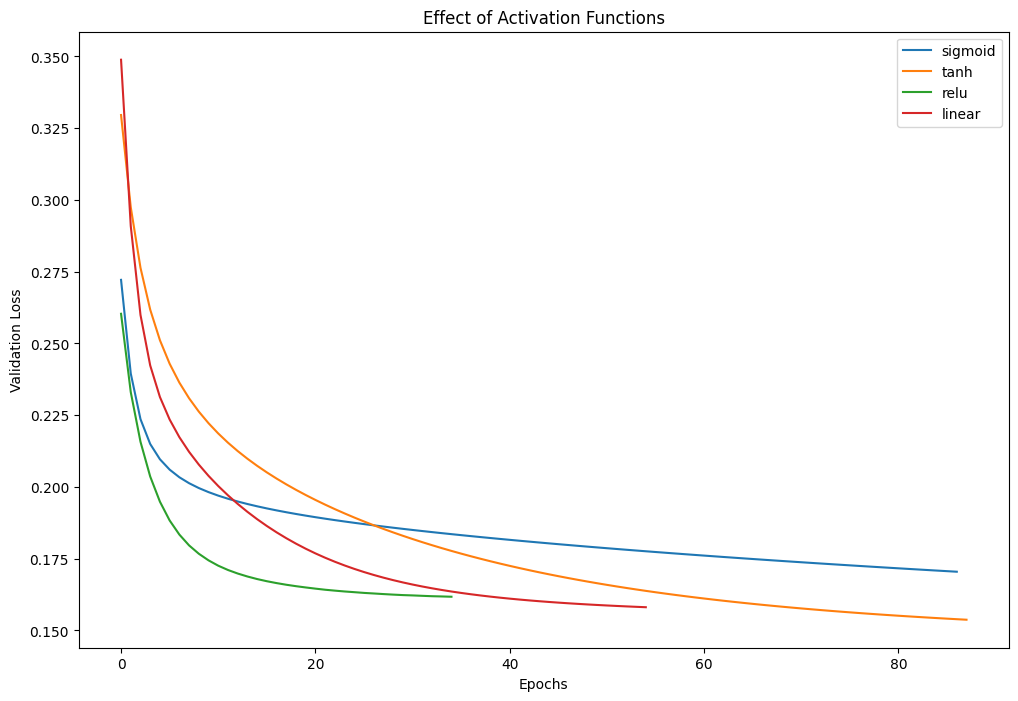

Epoch 100/500, Loss: 0.1771
Early stopping at epoch 121
Early stopping at epoch 27
Early stopping at epoch 14
Early stopping at epoch 7


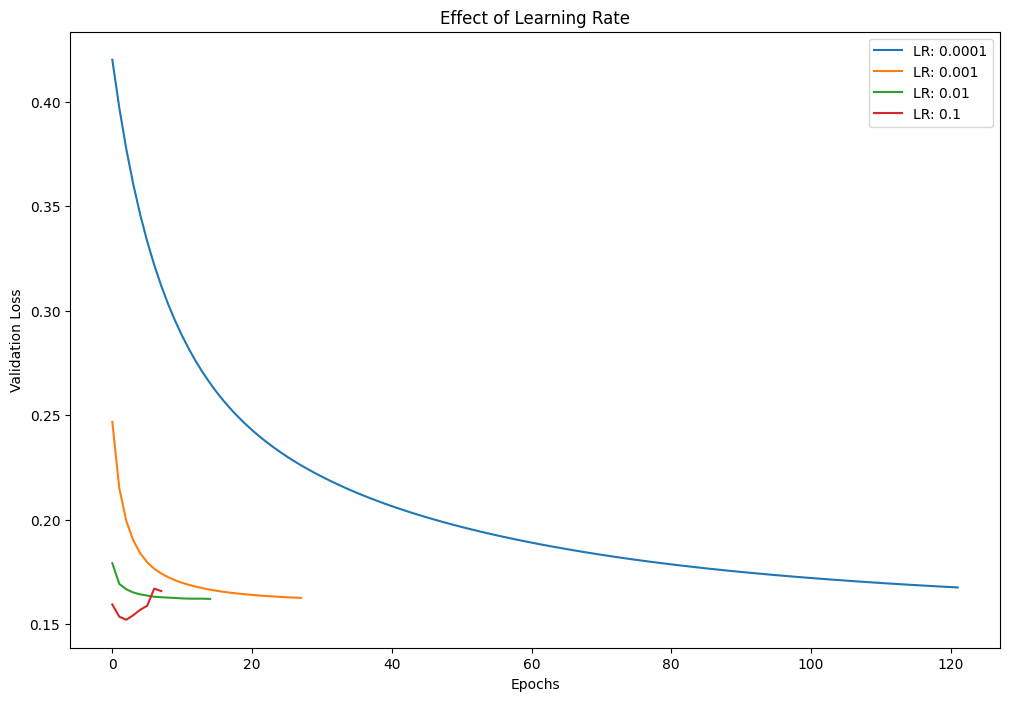

Early stopping at epoch 42
Early stopping at epoch 42
Early stopping at epoch 64
Early stopping at epoch 65


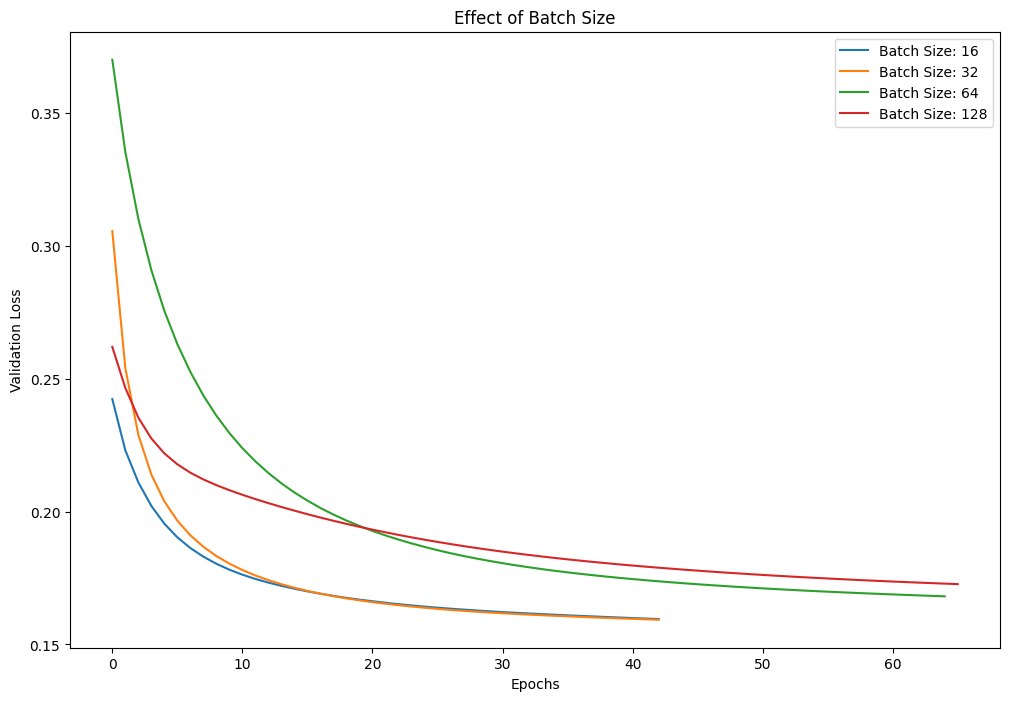

In [56]:
#With early stopping 
# Analyze hyperparameters
analyze_hyperparameters(X_train, y_train, X_val, y_val)

# Run multi-label classification
# multi_label_classification()

In [57]:

class ActivationFunction:
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-np.clip(x, -709, 709)))

    @staticmethod
    def sigmoid_derivative(x):
        return x * (1 - x)

    @staticmethod
    def tanh(x):
        return np.tanh(x)

    @staticmethod
    def tanh_derivative(x):
        return 1 - np.tanh(x)**2

    @staticmethod
    def relu(x):
        return np.maximum(0, x)

    @staticmethod
    def relu_derivative(x):
        return np.where(x > 0, 1, 0)

    @staticmethod
    def linear(x):
        return x

    @staticmethod
    def linear_derivative(x):
        return np.ones_like(x)

    @staticmethod
    def softmax(x):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / np.sum(e_x, axis=1, keepdims=True)

class MLPClassifier:
    def __init__(self, input_size, hidden_sizes, output_size, activation='relu', 
                 learning_rate=0.01, epochs=100, batch_size=32, optimizer='sgd', patience=5, min_delta=0.001):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.patience = patience
        self.min_delta = min_delta

        self.weights = []
        self.biases = []
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(1, len(layer_sizes)):
            self.weights.append(np.random.randn(layer_sizes[i-1], layer_sizes[i]) * np.sqrt(2. / layer_sizes[i-1]))
            self.biases.append(np.zeros((1, layer_sizes[i])))

        self.set_activation(activation)

    def set_activation(self, activation):
        if activation == 'sigmoid':
            self.activation = ActivationFunction.sigmoid
            self.activation_derivative = ActivationFunction.sigmoid_derivative
        elif activation == 'tanh':
            self.activation = ActivationFunction.tanh
            self.activation_derivative = ActivationFunction.tanh_derivative
        elif activation == 'relu':
            self.activation = ActivationFunction.relu
            self.activation_derivative = ActivationFunction.relu_derivative
        elif activation == 'linear':
            self.activation = ActivationFunction.linear
            self.activation_derivative = ActivationFunction.linear_derivative
        else:
            raise ValueError("Unsupported activation function")

    def forward_propagation(self, X):
        self.layer_outputs = [X]
        for i in range(len(self.weights)):
            z = np.dot(self.layer_outputs[-1], self.weights[i]) + self.biases[i]
            a = self.activation(z) if i < len(self.weights) - 1 else ActivationFunction.softmax(z)
            self.layer_outputs.append(a)
        return self.layer_outputs[-1]

    def backward_propagation(self, X, y):
        m = X.shape[0]
        delta = self.layer_outputs[-1] - y
        gradients = []
        for i in reversed(range(len(self.weights))):
            dW = np.dot(self.layer_outputs[i].T, delta) / m
            db = np.sum(delta, axis=0, keepdims=True) / m
            gradients.append((dW, db))
            if i > 0:
                delta = np.dot(delta, self.weights[i].T) * self.activation_derivative(self.layer_outputs[i])
        return list(reversed(gradients))

    def update_parameters(self, gradients):
        for i, (dW, db) in enumerate(gradients):
            self.weights[i] -= self.learning_rate * dW
            self.biases[i] -= self.learning_rate * db

    def fit(self, X, y, X_val=None, y_val=None):
        self.losses = []
        self.val_losses = []
        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(self.epochs):
            for i in range(0, X.shape[0], self.batch_size):
                batch_X = X[i:i+self.batch_size]
                batch_y = y[i:i+self.batch_size]
                
                y_pred = self.forward_propagation(batch_X)
                gradients = self.backward_propagation(batch_X, batch_y)
                self.update_parameters(gradients)
            
            loss = self.compute_loss(X, y)
            self.losses.append(loss)
            
            if X_val is not None and y_val is not None:
                val_loss = self.compute_loss(X_val, y_val)
                self.val_losses.append(val_loss)
                
                if val_loss < best_val_loss - self.min_delta:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1

                # if patience_counter >= self.patience:
                #     print(f"Early stopping at epoch {epoch}")
                #     break
            
            if (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch + 1}/{self.epochs}, Loss: {loss:.4f}")

    def predict(self, X):
        return np.argmax(self.forward_propagation(X), axis=1)

    def compute_loss(self, X, y):
        y_pred = self.forward_propagation(X)
        return -np.mean(y * np.log(y_pred + 1e-8))

    def gradient_checking(self, X, y, epsilon=1e-7):
        gradients = self.backward_propagation(X, y)
        for i, (dW, db) in enumerate(gradients):
            for j in range(dW.shape[0]):
                for k in range(dW.shape[1]):
                    self.weights[i][j, k] += epsilon
                    cost_plus = self.compute_loss(X, y)
                    self.weights[i][j, k] -= 2 * epsilon
                    cost_minus = self.compute_loss(X, y)
                    self.weights[i][j, k] += epsilon
                    
                    grad_approx = (cost_plus - cost_minus) / (2 * epsilon)
                    grad_backprop = dW[j, k]
                    
                    rel_error = abs(grad_backprop - grad_approx) / max(abs(grad_backprop), abs(grad_approx))
                    if rel_error > 1e-5:
                        print(f"Gradient Check Failed for W[{i}][{j},{k}]. Relative Error: {rel_error:.6f}")
                        return False
        
        print("Gradient Check Passed!")
        return True

Epoch 100/500, Loss: 0.1798
Epoch 200/500, Loss: 0.1707
Epoch 300/500, Loss: 0.1661
Epoch 400/500, Loss: 0.1635
Epoch 500/500, Loss: 0.1617
Epoch 100/500, Loss: 0.1479
Epoch 200/500, Loss: 0.1312
Epoch 300/500, Loss: 0.1203
Epoch 400/500, Loss: 0.1111
Epoch 500/500, Loss: 0.1026
Epoch 100/500, Loss: 0.1325
Epoch 200/500, Loss: 0.1144
Epoch 300/500, Loss: 0.1006
Epoch 400/500, Loss: 0.0887
Epoch 500/500, Loss: 0.0781
Epoch 100/500, Loss: 0.1542
Epoch 200/500, Loss: 0.1518
Epoch 300/500, Loss: 0.1508
Epoch 400/500, Loss: 0.1503
Epoch 500/500, Loss: 0.1499


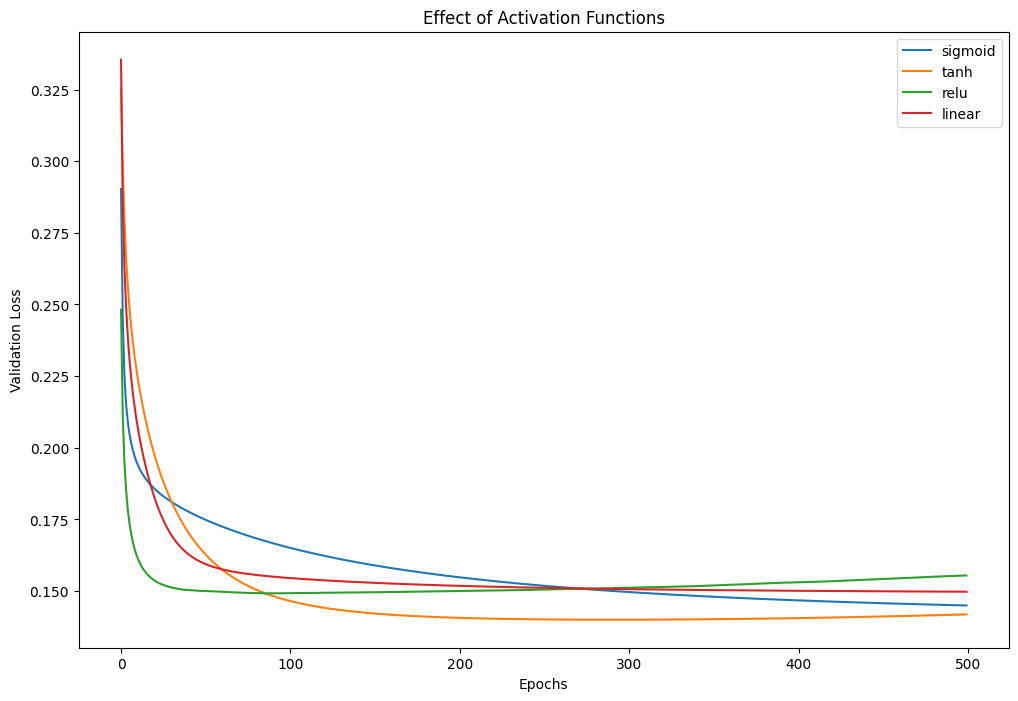

Epoch 100/500, Loss: 0.1822
Epoch 200/500, Loss: 0.1667
Epoch 300/500, Loss: 0.1576
Epoch 400/500, Loss: 0.1511
Epoch 500/500, Loss: 0.1462
Epoch 100/500, Loss: 0.1341
Epoch 200/500, Loss: 0.1153
Epoch 300/500, Loss: 0.1011
Epoch 400/500, Loss: 0.0891
Epoch 500/500, Loss: 0.0784
Epoch 100/500, Loss: 0.0579
Epoch 200/500, Loss: 0.0213
Epoch 300/500, Loss: 0.0080
Epoch 400/500, Loss: 0.0039
Epoch 500/500, Loss: 0.0025
Epoch 100/500, Loss: 0.0024
Epoch 200/500, Loss: 0.0003
Epoch 300/500, Loss: 0.0002
Epoch 400/500, Loss: 0.0001
Epoch 500/500, Loss: 0.0001


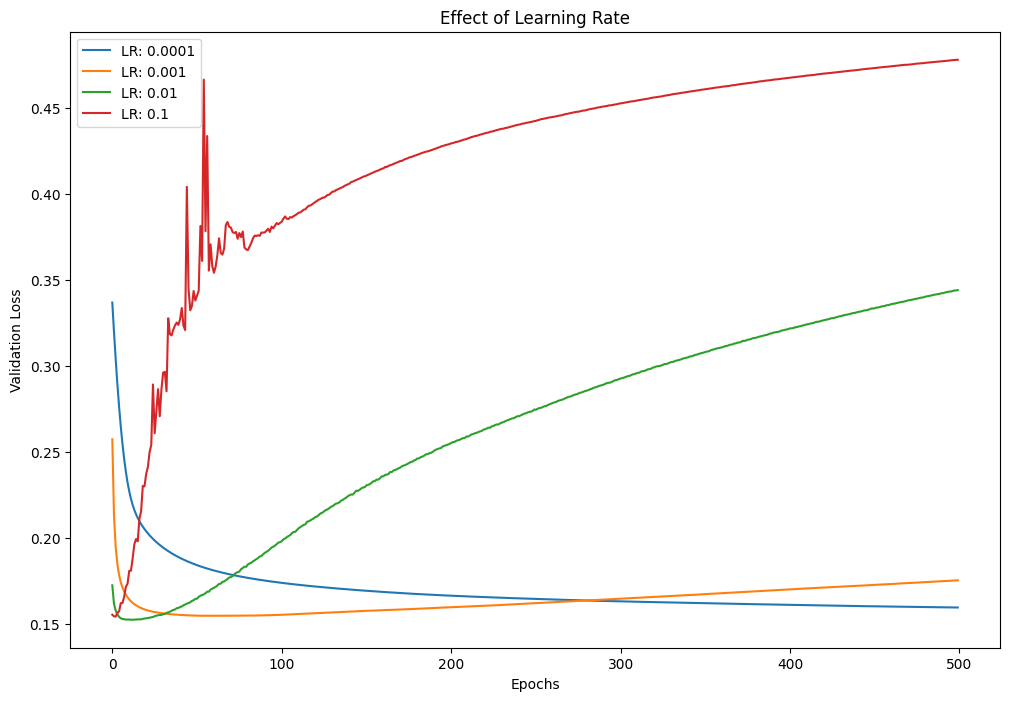

Epoch 100/500, Loss: 0.1282
Epoch 200/500, Loss: 0.1096
Epoch 300/500, Loss: 0.0961
Epoch 400/500, Loss: 0.0846
Epoch 500/500, Loss: 0.0743
Epoch 100/500, Loss: 0.1440
Epoch 200/500, Loss: 0.1303
Epoch 300/500, Loss: 0.1204
Epoch 400/500, Loss: 0.1121
Epoch 500/500, Loss: 0.1048
Epoch 100/500, Loss: 0.1608
Epoch 200/500, Loss: 0.1474
Epoch 300/500, Loss: 0.1393
Epoch 400/500, Loss: 0.1330
Epoch 500/500, Loss: 0.1277
Epoch 100/500, Loss: 0.1711
Epoch 200/500, Loss: 0.1597
Epoch 300/500, Loss: 0.1530
Epoch 400/500, Loss: 0.1481
Epoch 500/500, Loss: 0.1441


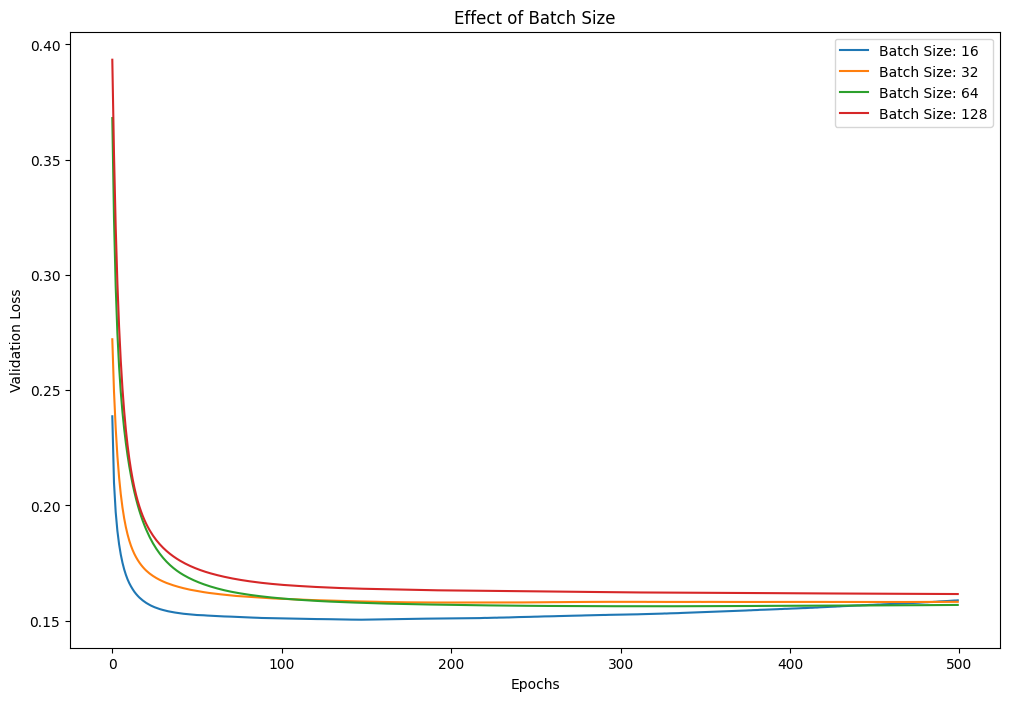

In [58]:
analyze_hyperparameters(X_train, y_train, X_val, y_val)

In [45]:
#Print best model parameters
# Print best model parameters
print("Best Model Parameters:")
print(f"Hidden Sizes: {best_model.hidden_sizes}")
print(f"Activation Function: {best_model.activation}")
print(f"Learning Rate: {best_model.learning_rate}")
print(f"Optimizer: {best_model.optimizer}")
print(f"Batch Size: {best_model.batch_size}")
print(f"Number of Epochs: {best_model.epochs}")


Best Model Parameters:
Hidden Sizes: [256, 128]
Activation Function: <function ActivationFunction.relu at 0x7ff5f4ccbe20>
Learning Rate: 0.001
Optimizer: sgd
Batch Size: 16
Number of Epochs: 500


In [67]:
class MultiLabelMLPClassifier:
    def __init__(self, input_size, hidden_sizes, output_size, activation='relu', 
                 learning_rate=0.01, epochs=100, batch_size=32, optimizer='sgd', patience=5, min_delta=0.001):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.patience = patience
        self.min_delta = min_delta

        self.weights = []
        self.biases = []
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(1, len(layer_sizes)):
            self.weights.append(np.random.randn(layer_sizes[i-1], layer_sizes[i]) * np.sqrt(2. / layer_sizes[i-1]))
            self.biases.append(np.zeros((1, layer_sizes[i])))

        self.set_activation(activation)

    def set_activation(self, activation):
        if activation == 'sigmoid':
            self.activation = ActivationFunction.sigmoid
            self.activation_derivative = ActivationFunction.sigmoid_derivative
        elif activation == 'tanh':
            self.activation = ActivationFunction.tanh
            self.activation_derivative = ActivationFunction.tanh_derivative
        elif activation == 'relu':
            self.activation = ActivationFunction.relu
            self.activation_derivative = ActivationFunction.relu_derivative
        elif activation == 'linear':
            self.activation = ActivationFunction.linear
            self.activation_derivative = ActivationFunction.linear_derivative
        else:
            raise ValueError("Unsupported activation function")

    def forward_propagation(self, X):
        self.layer_outputs = [X]
        for i in range(len(self.weights)):
            z = np.dot(self.layer_outputs[-1], self.weights[i]) + self.biases[i]
            a = self.activation(z) if i < len(self.weights) - 1 else ActivationFunction.sigmoid(z)
            self.layer_outputs.append(a)
        return self.layer_outputs[-1]

    def backward_propagation(self, X, y):
        m = X.shape[0]
        delta = self.layer_outputs[-1] - y
        gradients = []
        for i in reversed(range(len(self.weights))):
            dW = np.dot(self.layer_outputs[i].T, delta) / m
            db = np.sum(delta, axis=0, keepdims=True) / m
            gradients.append((dW, db))
            if i > 0:
                delta = np.dot(delta, self.weights[i].T) * self.activation_derivative(self.layer_outputs[i])
        return list(reversed(gradients))

    def update_parameters(self, gradients):
        for i, (dW, db) in enumerate(gradients):
            self.weights[i] -= self.learning_rate * dW
            self.biases[i] -= self.learning_rate * db

    def fit(self, X, y, X_val=None, y_val=None):
        self.losses = []
        self.val_losses = []
        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(self.epochs):
            for i in range(0, X.shape[0], self.batch_size):
                batch_X = X[i:i+self.batch_size]
                batch_y = y[i:i+self.batch_size]
                
                y_pred = self.forward_propagation(batch_X)
                gradients = self.backward_propagation(batch_X, batch_y)
                self.update_parameters(gradients)
            
            loss = self.compute_loss(X, y)
            self.losses.append(loss)
            
            if X_val is not None and y_val is not None:
                val_loss = self.compute_loss(X_val, y_val)
                self.val_losses.append(val_loss)
                
                if val_loss < best_val_loss - self.min_delta:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= self.patience:
                    print(f"Early stopping at epoch {epoch}")
                    break
            
            if (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch + 1}/{self.epochs}, Loss: {loss:.4f}")

    def predict(self, X):
        return (self.forward_propagation(X) > 0.5).astype(int)

    def compute_loss(self, X, y):
        y_pred = self.forward_propagation(X)
        return -np.mean(y * np.log(y_pred + 1e-8) + (1 - y) * np.log(1 - y_pred + 1e-8))

    def gradient_checking(self, X, y, epsilon=1e-7):
        gradients = self.backward_propagation(X, y)
        for i, (dW, db) in enumerate(gradients):
            for j in range(dW.shape[0]):
                for k in range(dW.shape[1]):
                    self.weights[i][j, k] += epsilon
                    cost_plus = self.compute_loss(X, y)
                    self.weights[i][j, k] -= 2 * epsilon
                    cost_minus = self.compute_loss(X, y)
                    self.weights[i][j, k] += epsilon
                    
                    grad_approx = (cost_plus - cost_minus) / (2 * epsilon)
                    grad_backprop = dW[j, k]
                    
                    rel_error = abs(grad_backprop - grad_approx) / max(abs(grad_backprop), abs(grad_approx))
                    if rel_error > 1e-5:
                        print(f"Gradient Check Failed for W[{i}][{j},{k}]. Relative Error: {rel_error:.6f}")
                        return False
        
        print("Gradient Check Passed!")
        return True

In [68]:
import wandb
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, hamming_loss

def train_and_evaluate_ml(X_train, y_train, X_val, y_val, X_test, y_test, config):
    model = MultiLabelMLPClassifier(
        input_size=X_train.shape[1],
        hidden_sizes=config['hidden_sizes'],
        output_size=y_train.shape[1],
        activation=config['activation'],
        learning_rate=config['learning_rate'],
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        optimizer=config['optimizer']
    )
    
    model.fit(X_train, y_train, X_val, y_val)
    
    y_pred = model.predict(X_test)
    y_true = y_test
    
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    hamming = hamming_loss(y_true, y_pred)
    
    return model, accuracy, f1, precision, recall, hamming

def hyperparameter_tuning_multilabel(X_train, y_train, X_val, y_val, X_test, y_test):
    # Define hyperparameters to tune
    hidden_sizes_list = [[64, 32], [128, 64], [256, 128]]
    activations = ['sigmoid', 'tanh', 'relu']
    learning_rates = [0.0001, 0.001, 0.01]
    epochs_list = [100, 500, 1000]
    batch_sizes = [16, 32, 64]
    optimizers = ['sgd', 'batch', 'mini-batch']

    best_model = None
    best_accuracy = 0
    best_config = None

    wandb.init(project='q2_final4_test', entity='vishnuvarun-iiit-hyderabad')

    for hidden_sizes, activation, lr, epochs, batch_size, optimizer in product(hidden_sizes_list, activations, learning_rates, epochs_list, batch_sizes, optimizers):
        config = {
            'hidden_sizes': hidden_sizes,
            'activation': activation,
            'learning_rate': lr,
            'epochs': epochs,
            'batch_size': batch_size,
            'optimizer': optimizer
        }
        
        print(f"Testing configuration: {config}")
        
        model, accuracy, f1, precision, recall, hamming = train_and_evaluate_ml(X_train, y_train, X_val, y_val, X_test, y_test, config)
        
        wandb.log({
            "accuracy": accuracy,
            "f1_score": f1,
            "precision": precision,
            "recall": recall,
            "hamming_loss": hamming
        })
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
            best_config = config

    print("Best Model Configuration:")
    print(best_config)
    wandb.finish()
    return best_model



In [12]:
def evaluate_best_model_ml(X_test_standardized, y_test, X_val_standardized, y_val, best_model):
    # print("Best Model Parameters:")
    # print(f"Hidden Sizes: {best_model.hidden_sizes}")
    # print(f"Activation Function: {best_model.activation}")
    # print(f"Learning Rate: {best_model.learning_rate}")
    # print(f"Optimizer: {best_model.optimizer}")
    # print(f"Batch Size: {best_model.batch_size}")
    # print(f"Number of Epochs: {best_model.epochs}")
    
    # Evaluate on validation set
    y_pred_val = best_model.predict(X_val_standardized)
    y_true_val = y_val
    
    val_accuracy = accuracy_score(y_true_val, y_pred_val)
    val_f1 = f1_score(y_true_val, y_pred_val, average='weighted')
    val_precision = precision_score(y_true_val, y_pred_val, average='weighted')
    val_recall = recall_score(y_true_val, y_pred_val, average='weighted')
    val_hamming = hamming_loss(y_true_val, y_pred_val)
    
    print("\nValidation Set Metrics:")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation F1 Score: {val_f1:.4f}")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Validation Hamming Loss: {val_hamming:.4f}")
    
    # Evaluate on test set
    y_pred_test = best_model.predict(X_test_standardized)
    y_true_test = y_test
    
    test_accuracy = accuracy_score(y_true_test, y_pred_test)
    test_f1 = f1_score(y_true_test, y_pred_test, average='weighted')
    test_precision = precision_score(y_true_test, y_pred_test, average='weighted')
    test_recall = recall_score(y_true_test, y_pred_test, average='weighted')
    test_hamming = hamming_loss(y_true_test, y_pred_test)
    
    print("\nTest Set Metrics:")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test Hamming Loss: {test_hamming:.4f}")
    
    
def analyze_classification_performance_ml(y_true, y_pred, class_labels):
    class_metrics = {}
    for i, label in enumerate(class_labels):
        true_class = y_true[:, i]
        pred_class = y_pred[:, i]
        
        accuracy = accuracy_score(true_class, pred_class)
        f1 = f1_score(true_class, pred_class)
        precision = precision_score(true_class, pred_class)
        recall = recall_score(true_class, pred_class)
        
        class_metrics[label] = {
            'accuracy': accuracy,
            'f1_score': f1,
            'precision': precision,
            'recall': recall
        }
    
    for label, metrics in class_metrics.items():
        print(f"Class: {label}")
        print(f"  Accuracy: {metrics['accuracy']:.4f}")
        print(f"  F1 Score: {metrics['f1_score']:.4f}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall: {metrics['recall']:.4f}")
        print()


In [70]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv('../../data/external/advertisement.csv')

# Drop the 'city' column as it's not needed
df = df.drop('city', axis=1)

# One-hot encode categorical features
X = pd.get_dummies(df.drop('labels', axis=1), columns=['gender', 'education', 'married', 'occupation', 'most bought item'])
X = np.array(X).astype(float)

# Process the labels into a suitable format for multi-label classification
y = df['labels'].str.split()  # Split labels into lists of labels
unique_labels = set(label for labels in y for label in labels)
label_to_index = {label: i for i, label in enumerate(unique_labels)}

# Map labels to binary format
y_binary = np.zeros((len(y), len(unique_labels)), dtype=int)
for i, labels in enumerate(y):
    for label in labels:
        y_binary[i, label_to_index[label]] = 1

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_binary, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_val_standardized = scaler.transform(X_val)
X_test_standardized = scaler.transform(X_test)

# # Assuming X_train, y_train, X_val, y_val, X_test, y_test are already defined and preprocessed
# X_train, y_train = X_train_standardized, y_train
# X_val, y_val = X_val_standardized, y_val
# X_test, y_test = X_test_standardized, y_test

In [71]:

# Perform hyperparameter tuning
best_model = hyperparameter_tuning_multilabel(X_train, y_train, X_val, y_val, X_test, y_test)


Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}
Epoch 100/100, Loss: 0.6589
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.6749
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.6542
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.6813
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.6714
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 93
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.7516
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.6938
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 82
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.6570
Early stopping at epoch 131
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.6557
Early stopping at epoch 123
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.6565
Early stopping at epoch 129
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.6740
Early stopping at epoch 153
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.6848
Early stopping at epoch 186
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.6796
Early stopping at epoch 171
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.7360
Epoch 200/500, Loss: 0.6957
Early stopping at epoch 278
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.7169
Epoch 200/500, Loss: 0.6814
Early stopping at epoch 247
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.6955
Early stopping at epoch 198
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 92
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.6640
Early stopping at epoch 142
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.6515
Early stopping at epoch 102
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.6877
Epoch 200/1000, Loss: 0.6584
Early stopping at epoch 205
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.6846
Early stopping at epoch 197
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.6665
Early stopping at epoch 145
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.7216
Epoch 200/1000, Loss: 0.6869
Early stopping at epoch 258
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.6785
Early stopping at epoch 163
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.7467
Epoch 200/1000, Loss: 0.7023
Epoch 300/1000, Loss: 0.6782
Early stopping at epoch 345
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 22
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 32
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 21
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 41
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 35
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 44
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 53
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 68
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 74
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 29
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 23
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 33
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 40
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 38
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 83
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 59
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 62
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 27
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 25
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 40
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 41
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 46
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 53
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 70
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 58
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 11
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 11
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 12
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 14
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 19
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 12
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 11
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 11
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 18
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 14
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 15
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 10
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 11
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 21
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 13
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 19
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 11
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}
Early stopping at epoch 17
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 12
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 15
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}
Early stopping at epoch 10
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}
Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}
Early stopping at epoch 10
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}
Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}
Early stopping at epoch 6


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}
Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}
Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}
Early stopping at epoch 13
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}
Early stopping at epoch 13
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}
Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}
Early stopping at epoch 10
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Early stopping at epoch 18
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}
Early stopping at epoch 13


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}
Early stopping at epoch 12
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}
Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}
Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 15
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}
Early stopping at epoch 10
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 11
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 13
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 12
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}
Early stopping at epoch 6


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}
Early stopping at epoch 14
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}
Early stopping at epoch 10
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 16
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}
Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}
Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}
Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}
Early stopping at epoch 12
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}
Early stopping at epoch 10


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}
Early stopping at epoch 16
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 12
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}
Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 16
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}
Early stopping at epoch 11
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 11
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 10
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}
Early stopping at epoch 10
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 10
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}
Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 10
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}
Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}
Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}
Early stopping at epoch 13
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}
Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Early stopping at epoch 25
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}
Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}
Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}
Early stopping at epoch 10
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}
Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate'

/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Early stopping at epoch 12
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}
Early stopping at epoch 10
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}
Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}
Early stopping at epoch 9

/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)


Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}
Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 15
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}
Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 12
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}
Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 13
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}
Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}
Early stopping at epoch 20
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'lear

/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}
Early stopping at epoch 13
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}
Early stopping at epoch 48
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Early stopping at epoch 15
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 30
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}
Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Early stopping at epoch 58
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Early stopping at epoch 43
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}
Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Early stopping at epoch 99
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 99
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 99
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.6638
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.6638
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.6638
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 67
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 78
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 99
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 99
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 99
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.6638
Early stopping at epoch 114
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.6638
Early stopping at epoch 114
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.6638
Early stopping at epoch 114
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}
Early stopping at epoch 78


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}
Early stopping at epoch 78
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 78
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 99
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 99
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 99
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.6638
Early stopping at epoch 114
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.6638
Early stopping at epoch 114
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.6638
Early stopping at epoch 114
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 78
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 78
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 78
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}
Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}
Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 41
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 41
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 41
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 64
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 64
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 64
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 41
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 41
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 41
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 64
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 64
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 64
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 31
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}
Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 29
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}
Early stopping at epoch 41
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 41
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}
Early stopping at epoch 41
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 64
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 64
Testing configuration: {'hidden_sizes': [64, 32], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 64
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 85
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 48
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 73
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.6585
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.6578
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.6538
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 72
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.6708
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.7041
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 68
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 88
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 65
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.6584
Early stopping at epoch 128
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.6613
Early stopping at epoch 142
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.6551
Early stopping at epoch 108
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.6691
Early stopping at epoch 122
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.6966
Early stopping at epoch 196
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 76
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 96
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 52
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 84
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.6599
Early stopping at epoch 136
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 85
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.6552
Early stopping at epoch 103
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.6662
Early stopping at epoch 144
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.6675
Early stopping at epoch 133
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.6712
Early stopping at epoch 124
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 19
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 17
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 19
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 16
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 22
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 25
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 40
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 43
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 35
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 16
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 18
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 18
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 33
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 23
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 34
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 39
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 34
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 14
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 18
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 18
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 30
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 26
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 46
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 47
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 53
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 11
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 13
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 10
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 10
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 14
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 14
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}
Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}
Early stopping at epoch 12
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}
Early stopping at epoch 14
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 10
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 12
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 14
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}
Early stopping at epoch 10
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 20
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}
Early stopping at epoch 10
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}
Early stopping at epoch 11
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}
Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 17
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}
Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 19
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}
Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 13
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}
Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}
Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}
Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}
Early stopping at epoch 12
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}
Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 14
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}
Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 13
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}
Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}
Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}
Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}
Early stopping at epoch 13
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}
Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 10
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}
Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}
Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}
Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}
Early stopping at epoch 11


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}
Early stopping at epoch 15
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}
Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 15
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}
Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}
Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}
Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Early stopping at epoch 10
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 10
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 13
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}
Early stopping at epoch 21
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}
Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}
Early stopping at epoch 6


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}
Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 13
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 14
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}
Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 19
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}
Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 12
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}
Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 13
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 16
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Early stopping at epoch 14
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 24
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 67
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 12
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}
Early stopping at epoch 23

/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.6667
Early stopping at epoch 103
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 14
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}
Early stopping at epoch 23
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}
Early stopping at epoch 11
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}
Early stopping at epoch 12
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 61
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}
Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 51
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Early stopping at epoch 22
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 99
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 99
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 99
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 53
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.6638
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.6638
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 78
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 78
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 77
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 99
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 99
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 99
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.6638
Early stopping at epoch 114
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.6638
Early stopping at epoch 114
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.6638
Early stopping at epoch 114
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 78
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 78
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 78
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 99
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 99
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 99
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.6638
Early stopping at epoch 114
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.6638
Early stopping at epoch 114
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.6638
Early stopping at epoch 114
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 78
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 78
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 74
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 27
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 41
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 41
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 41
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 64
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 64
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 64
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 41
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 41
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 41
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 64
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 64
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 64
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 41
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 41
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 41
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 64
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 64
Testing configuration: {'hidden_sizes': [128, 64], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 64
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 64
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 53
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 43
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 75
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 79
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 69
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.6539
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.6578
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.6663
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 48
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 52
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 54
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 79
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 86
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 70
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.6595
Early stopping at epoch 146
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.6547
Early stopping at epoch 114
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 83
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 49
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 55
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 38
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 88
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 81
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 83
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.6535
Early stopping at epoch 102
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.6577
Early stopping at epoch 130
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.6577
Early stopping at epoch 106
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 11
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 12
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 19
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 19
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 19
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 26
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 33
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 24
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 12
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 12
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 13
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 19
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 18
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 20
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 26
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 21
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 29
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 13
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 10
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 11
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 15
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 19
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 18
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 19
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 23
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 25
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 10
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 16
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 10
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 14
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 10
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 13
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 13
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 12
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 13
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 18
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 10
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 10
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 14
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 11
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 10
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 15
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 10
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 11
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}
Early stopping at epoch 7


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}
Early stopping at epoch 12
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 10
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 13
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 26
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 12
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 23
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 21
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 13
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 11
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 19
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 10
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}
Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 14
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 12
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 11
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 11
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 8
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 12
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 7
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 6
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 13
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 24
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 16
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 37
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 50
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 11
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 98
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}
Early stopping at epoch 9
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 34
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 53
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 17
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 46
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 18
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 61
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 58
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}
Early stopping at epoch 5


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}
Early stopping at epoch 12
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 50
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 36
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 50
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 13
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}
Early stopping at epoch 5
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 50
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.0001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 23
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 99
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 97
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 99
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.6638
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.6599
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/100, Loss: 0.6638
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 78
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 78
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 78
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 99
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.6538
Early stopping at epoch 100
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 99
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.6638
Early stopping at epoch 114
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/500, Loss: 0.6638
Early stopping at epoch 114
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 62
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 78
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 78
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 78
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 99
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 99
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 99
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.6635
Early stopping at epoch 116
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.6638
Early stopping at epoch 114
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100/1000, Loss: 0.6638
Early stopping at epoch 114
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 78
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 78
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 58
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 41
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 41
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 41
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 64
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 64
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 64
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 41
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 45
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 41
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 64
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 64
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 500, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 64
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 31
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 16, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 28
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 41
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 41
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 32, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 41
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'sgd'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 64
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 64
Testing configuration: {'hidden_sizes': [256, 128], 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 1000, 'batch_size': 64, 'optimizer': 'mini-batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Early stopping at epoch 64
Best Model Configuration:
{'hidden_sizes': [64, 32], 'activation': 'sigmoid', 'learning_rate': 0.0001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'batch'}


/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


accuracy,▁▁▃▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▆▁▁▁▁▁▆▁▁▁▁▁▁
f1_score,▂▁▁▁▁▁▁▁▄▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▇▂█▁▁▁▁▁▁▁▂▁▁▁
hamming_loss,█▁▄▁▁▁▁▁▁▁▁▁▁▅▁▁▅▁▁▁▁▃▅▁█▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▆▁▁▁▁▁▁▁▁▁▁▁█▁▁
recall,▆▁▁▁▁▁▃▁█▁▁▁▁▁▁▁▁▃▁▁▁▃██▃▁▁▁▁▁▁▁▁▁▁▁▄▆▆▁
accuracy,0
f1_score,0
hamming_loss,0.33417
precision,0
recall,0


In [72]:

# Evaluate the best model
evaluate_best_model_ml(X_test, y_test, X_val, y_val, best_model)

# Analyze classification performance
class_labels = [f"Class {i}" for i in range(y_test.shape[1])]
analyze_classification_performance_ml(y_test, best_model.predict(X_test), class_labels)

Best Model Parameters:
Hidden Sizes: [64, 32]
Activation Function: <function ActivationFunction.sigmoid at 0x7ff5ffd9a3e0>
Learning Rate: 0.0001
Optimizer: batch
Batch Size: 32
Number of Epochs: 100

Validation Set Metrics:
Validation Accuracy: 0.0133
Validation F1 Score: 0.1023
Validation Precision: 0.0661
Validation Recall: 0.2266
Validation Hamming Loss: 0.4250

Test Set Metrics:
Test Accuracy: 0.0267
Test F1 Score: 0.1340
Test Precision: 0.0904
Test Recall: 0.2594
Test Hamming Loss: 0.4108
Class: Class 0
  Accuracy: 0.6933
  F1 Score: 0.0000
  Precision: 0.0000
  Recall: 0.0000

Class: Class 1
  Accuracy: 0.6533
  F1 Score: 0.0000
  Precision: 0.0000
  Recall: 0.0000

Class: Class 2
  Accuracy: 0.6733
  F1 Score: 0.0000
  Precision: 0.0000
  Recall: 0.0000

Class: Class 3
  Accuracy: 0.6867
  F1 Score: 0.0000
  Precision: 0.0000
  Recall: 0.0000

Class: Class 4
  Accuracy: 0.3200
  F1 Score: 0.4848
  Precision: 0.3200
  Recall: 1.0000

Class: Class 5
  Accuracy: 0.6467
  F1 Score: 

/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srivishnuvarun/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/

In [4]:
import numpy as np
import wandb

class MLPClassifierMultilabel:
    def __init__(self, num_hidden_layers=1, num_neurons=64, activation='relu', learning_rate=0.01, num_classes=6):
        self.num_hidden_layers = num_hidden_layers
        self.num_neurons = num_neurons
        self.activation = activation
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.weights = []
        self.biases = []
        self.activations = [self.activation] * (num_hidden_layers + 1)
        self.activations[-1] = 'sigmoid' 

    def initialize_weights_and_biases(self, input_dim):
        layer_sizes = [input_dim] + [self.num_neurons] * self.num_hidden_layers + [self.num_classes]
        for i in range(1, len(layer_sizes)):
            input_size, output_size = layer_sizes[i - 1], layer_sizes[i]
            weight = np.random.randn(input_size, output_size) * 0.01
            bias = np.zeros((1, output_size))
            self.weights.append(weight)
            self.biases.append(bias)

    def compute_loss(self, y_true, y_pred):
        # Clip predictions to avoid log(0)
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        m = len(y_true)
        loss = -1/m * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        return loss

    def activate(self, x, activation_type):
        if activation_type == 'relu':
            return np.maximum(0, x)
        elif activation_type == 'sigmoid':
            x = np.clip(x, -500, 500)
            return 1 / (1 + np.exp(-x))
        elif activation_type == 'tanh':
            return np.tanh(x)

    def d_relu(self, x):
        return np.where(x > 0, 1, 0)

    def d_sigmoid(self, x):
        return x * (1 - x)

    def d_tanh(self, x):
        return 1 - np.tanh(x) ** 2

    def forward_propagation(self, x):
        z_values = []
        a_values = [x]
        for i in range(self.num_hidden_layers):
            z = np.dot(a_values[i], self.weights[i]) + self.biases[i]
            a = self.activate(z, self.activations[i])
            z_values.append(z)
            a_values.append(a)

        # Output layer with sigmoid activation for multilabel classification
        z = np.dot(a_values[-1], self.weights[-1]) + self.biases[-1]
        a = self.activate(z, self.activations[-1])
        z_values.append(z)
        a_values.append(a)

        return z_values, a_values

    def backward_propagation(self, x, y):
        m = x.shape[0]
        z_values, a_values = self.forward_propagation(x)
        gradients = [None] * (self.num_hidden_layers + 1)

        # Compute gradient of the output layer
        gradients[-1] = a_values[-1] - y

        # Backpropagate through hidden layers
        for i in reversed(range(self.num_hidden_layers)):
            if self.activations[i] == 'relu':
                gradients[i] = np.dot(gradients[i + 1], self.weights[i + 1].T) * self.d_relu(a_values[i + 1])
            elif self.activations[i] == 'sigmoid':
                gradients[i] = np.dot(gradients[i + 1], self.weights[i + 1].T) * self.d_sigmoid(a_values[i + 1]) # Perform hyperparameter tuning
            elif self.activations[i] == 'tanh':
                gradients[i] = np.dot(gradients[i + 1], self.weights[i + 1].T) * self.d_tanh(a_values[i + 1])

        # Compute gradients for weights and biases
        dW = [None] * (self.num_hidden_layers + 1)
        db = [None] * (self.num_hidden_layers + 1)
        for i in range(self.num_hidden_layers + 1):
            dW[i] = np.dot(a_values[i].T, gradients[i]) / m
            db[i] = np.sum(gradients[i], axis=0) / m

        return dW, db

    def predict(self, x, threshold=0.5):
        _, y_pred = self.forward_propagation(x)
        shifted_y_pred = (y_pred[-1] > threshold).astype(int)
        return shifted_y_pred

    def fit(self, x, y, optimizer='sgd', batch_size=32, num_epochs=1000):
        input_dim = x.shape[1]
        self.initialize_weights_and_biases(input_dim)
        
        m = x.shape[0]  # Number of training samples

        for epoch in range(num_epochs):
            if optimizer == 'sgd':
                for i in range(m):
                    random_index = np.random.randint(0, m)
                    x_sample = x[random_index:random_index + 1]
                    y_sample = y[random_index:random_index + 1]
                    dW, db = self.backward_propagation(x_sample, y_sample)
                    for j in range(self.num_hidden_layers + 1):
                        self.weights[j] -= self.learning_rate * dW[j]
                        self.biases[j] -= self.learning_rate * db[j]

            elif optimizer == 'batch':
                dW, db = self.backward_propagation(x, y)
                for j in range(self.num_hidden_layers + 1):
                    self.weights[j] -= self.learning_rate * dW[j]
                    self.biases[j] -= self.learning_rate * db[j]

            elif optimizer == 'mini-batch':
                indices = np.arange(m)
                np.random.shuffle(indices)
                x_shuffled = x[indices]
                y_shuffled = y[indices]
                for i in range(0, m, batch_size):
                    x_batch = x_shuffled[i:i+batch_size]
                    y_batch = y_shuffled[i:i+batch_size]
                    dW, db = self.backward_propagation(x_batch, y_batch)
                    for j in range(self.num_hidden_layers + 1):
                        self.weights[j] -= self.learning_rate * dW[j]
                        self.biases[j] -= self.learning_rate * db[j]

            _, y_pred = self.forward_propagation(x)
            loss = self.compute_loss(y, y_pred[-1])
            wandb.log({f"Loss Optimizer={optimizer} Epochs={num_epochs} Learning Rate={self.learning_rate} Num_hidden_layers={self.num_hidden_layers} Num_neurons={self.num_neurons} Activation={self.activation}": loss})
            self.evaluate_model(x, y)

            if (epoch + 1) % 100 == 0:
                print(f"{optimizer.capitalize()} Epoch {epoch + 1}/{num_epochs}, Loss: {loss:.4f}")

        print(f"{optimizer.capitalize()} Training complete!")

    def evaluate_model(self, x, y, isTrain=True):
        _, y_pred = self.forward_propagation(x)
        shifted_y_pred = (y_pred[-1] > 0.5).astype(int)
        accuracy = np.mean(np.all(shifted_y_pred == y, axis=1))
        if isTrain:
            wandb.log({f"Train_accuracy Learning Rate={self.learning_rate} Num_hidden_layers={self.num_hidden_layers} Num_neurons={self.num_neurons} Activation={self.activation}": accuracy})
        else:
            wandb.log({f"Validation_accuracy Learning Rate={self.learning_rate} Num_hidden_layers={self.num_hidden_layers} Num_neurons={self.num_neurons} Activation={self.activation}": accuracy})

Loss Optimizer=sgd Epochs=500 Learning Rate=0.01 Num_hidden_layers=1 Num_neurons=64 Activation=relu,█▃▃▃▂▁▁
Train_accuracy Learning Rate=0.01 Num_hidden_layers=1 Num_neurons=64 Activation=relu,▁▂▃▃▄▅▆▆▆▆▆▆▆▇▇▇████████████████████████
Loss Optimizer=sgd Epochs=500 Learning Rate=0.01 Num_hidden_layers=1 Num_neurons=64 Activation=relu,nan
Train_accuracy Learning Rate=0.01 Num_hidden_layers=1 Num_neurons=64 Activation=relu,0.99857


Sgd Epoch 100/500, Loss: 0.3012
Sgd Epoch 200/500, Loss: 0.0400
Sgd Epoch 300/500, Loss: 0.0328
Sgd Epoch 400/500, Loss: 0.0298
Sgd Epoch 500/500, Loss: 0.0264
Sgd Training complete!
Batch Epoch 100/500, Loss: 5.3983
Batch Epoch 200/500, Loss: 5.3084
Batch Epoch 300/500, Loss: 5.2515
Batch Epoch 400/500, Loss: 5.2129
Batch Epoch 500/500, Loss: 5.1831
Batch Training complete!
Mini-batch Epoch 100/500, Loss: 3.8421
Mini-batch Epoch 200/500, Loss: 3.3741
Mini-batch Epoch 300/500, Loss: 2.9258
Mini-batch Epoch 400/500, Loss: 2.4685
Mini-batch Epoch 500/500, Loss: 2.0580
Mini-batch Training complete!
Sgd Epoch 100/500, Loss: 1.7820
Sgd Epoch 200/500, Loss: 0.4745
Sgd Epoch 300/500, Loss: 0.2171
Sgd Epoch 400/500, Loss: 0.1349
Sgd Epoch 500/500, Loss: 0.0959
Sgd Training complete!
Batch Epoch 100/500, Loss: 5.1874
Batch Epoch 200/500, Loss: 5.1867
Batch Epoch 300/500, Loss: 5.1862
Batch Epoch 400/500, Loss: 5.1856
Batch Epoch 500/500, Loss: 5.1849
Batch Training complete!
Mini-batch Epoch 10

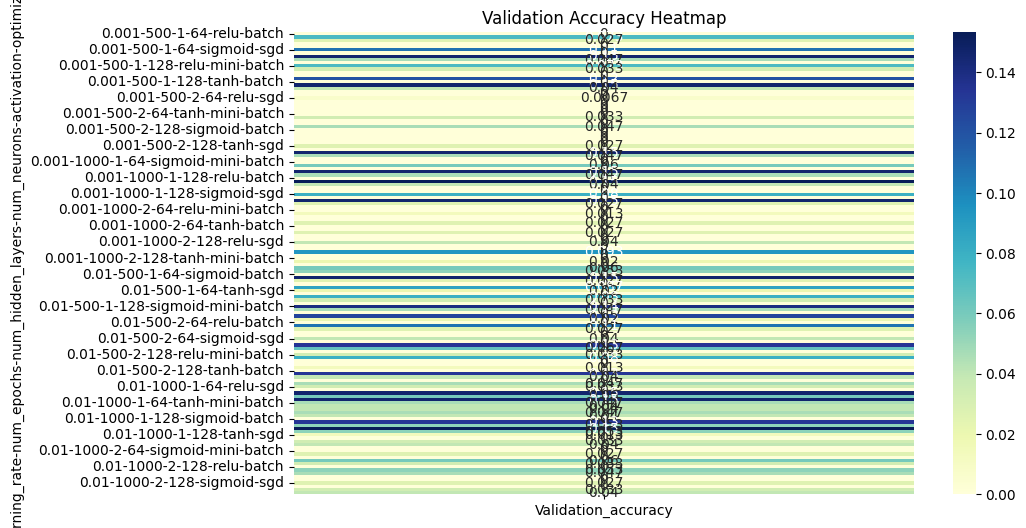

Hyperparameters for the Best Model:
learning_rate: 0.01
num_epochs: 1000
num_hidden_layers: 1
num_neurons: 128
activation: tanh
optimizer: batch
+---------------+------------------+-------------------------+-------------------+---------------------+------------+----------------------+---------------------+---------------------+---------------------+
| Learning Rate | Number of Epochs | Number of Hidden Layers | Number of Neurons | Activation Function | Optimizer  |       Accuracy       |       F1 Score      |      Precision      |        Recall       |
+---------------+------------------+-------------------------+-------------------+---------------------+------------+----------------------+---------------------+---------------------+---------------------+
|      0.01     |       500        |            1            |         64        |         relu        |    sgd     | 0.05333333333333334  |  0.5293864618348252 |  0.494472044013093  |  0.5807291666666666 |
|      0.01     |       500

Loss Optimizer=batch Epochs=1000 Learning Rate=0.001 Num_hidden_layers=1 Num_neurons=128 Activation=relu,██▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Loss Optimizer=batch Epochs=1000 Learning Rate=0.001 Num_hidden_layers=1 Num_neurons=128 Activation=sigmoid,█▇▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss Optimizer=batch Epochs=1000 Learning Rate=0.001 Num_hidden_layers=1 Num_neurons=128 Activation=tanh,█████▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁
Loss Optimizer=batch Epochs=1000 Learning Rate=0.001 Num_hidden_layers=1 Num_neurons=64 Activation=relu,████▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁
Loss Optimizer=batch Epochs=1000 Learning Rate=0.001 Num_hidden_layers=1 Num_neurons=64 Activation=sigmoid,█▆▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss Optimizer=batch Epochs=1000 Learning Rate=0.001 Num_hidden_layers=1 Num_neurons=64 Activation=tanh,██▇▇▇▇▆▆▆▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Loss Optimizer=batch Epochs=1000 Learning Rate=0.001 Num_hidden_layers=2 Num_neurons=128 Activation=relu,█████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▃▃▃▃▃▃▂▁▁▁▁▁
Loss Optimizer=batch Epochs=1000 Learning Rate=0.001 Num_hidden_layers=2 Num_neurons=128 Activation=sigmoid,█▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss Optimizer=batch Epochs=1000 Learning Rate=0.001 Num_hidden_layers=2 Num_neurons=128 Activation=tanh,████▇▆▆▆▆▆▆▆▅▅▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁
Loss Optimizer=batch Epochs=1000 Learning Rate=0.001 Num_hidden_layers=2 Num_neurons=64 Activation=relu,████▇▇▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Loss Optimizer=batch Epochs=1000 Learning Rate=0.001 Num_hidden_layers=2 Num_neurons=64 Activation=sigmoid,█▆▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [59]:
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import wandb

# Load and preprocess the data
df = pd.read_csv('../../data/external/advertisement.csv')
df = df.drop('city', axis=1)
X = pd.get_dummies(df.drop('labels', axis=1), columns=['gender', 'education', 'married', 'occupation', 'most bought item'])
X = np.array(X).astype(float)
y = df['labels']

# Process the labels into a suitable format for multilabel classification
y = y.str.split()  # Split labels into lists of labels
unique_labels = set(label for labels in y for label in labels)
label_to_index = {label: i for i, label in enumerate(unique_labels)}

# Map labels to binary format
y_binary = np.zeros((len(y), len(unique_labels)), dtype=int)
for i, labels in enumerate(y):
    for label in labels:
        y_binary[i, label_to_index[label]] = 1

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_binary, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_val_standardized = scaler.transform(X_val)
X_test_standardized = scaler.transform(X_test)

# Initialize W&B
wandb.init(project='q2_4_test', entity='vishnuvarun-iiit-hyderabad')
best_accuracy = 0
best_model = None
best_hyperparameters = None

# Define hyperparameters to tune
learning_rates = [0.01, 0.001]
num_epochs = [500, 1000]
num_hidden_layers = [1, 2]
num_neurons = [64, 128]
activations = ['relu', 'sigmoid', 'tanh']
optimizers = ['sgd', 'batch', 'mini-batch']

metrics_table = PrettyTable()
metrics_table.field_names = ["Learning Rate", "Number of Epochs", "Number of Hidden Layers", "Number of Neurons", "Activation Function", "Optimizer", "Accuracy", "F1 Score", "Precision", "Recall"]

# Initialize a dictionary to collect metrics and hyperparameters
hyperparameter_metrics = {
    'learning_rate': [],
    'num_epochs': [],
    'num_hidden_layers': [],
    'num_neurons': [],
    'activation': [],
    'optimizer': [],
    'Validation_accuracy': [],
}

# Perform hyperparameter tuning
for lr, epochs, num_layers, num_neurons, activation, optimizer in product(learning_rates, num_epochs, num_hidden_layers, num_neurons, activations, optimizers):
    
    config = {
        'learning_rate': lr,
        'num_epochs': epochs,
        'num_hidden_layers': num_layers,
        'num_neurons': num_neurons,
        'activation': activation,
        'optimizer': optimizer
    }
    wandb.config.update(config)

    model = MLPClassifierMultilabel(
        num_hidden_layers=num_layers,
        num_neurons=num_neurons,
        activation=activation,
        learning_rate=lr,
        num_classes=len(unique_labels)
    )
    
    # Use the fit method with the specified optimizer
    model.fit(X_train_standardized, y_train, optimizer=optimizer, num_epochs=epochs)
    model.evaluate_model(X_val_standardized, y_val, isTrain=False)
    y_pred_val = model.predict(X_val_standardized)
    
    # Calculate and report metrics
    accuracy = accuracy_score(y_val, y_pred_val)
    f1 = f1_score(y_val, y_pred_val, average='weighted', zero_division=1) 
    precision = precision_score(y_val, y_pred_val, average='weighted', zero_division=1)
    recall = recall_score(y_val, y_pred_val, average='weighted', zero_division=1)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_hyperparameters = {
            'learning_rate': lr,
            'num_epochs': epochs,
            'num_hidden_layers': num_layers,
            'num_neurons': num_neurons,
            'activation': activation,
            'optimizer': optimizer
        }
        
    metrics_table.add_row([lr, epochs, num_layers, num_neurons, activation, optimizer, accuracy, f1, precision, recall])
    
    hyperparameter_metrics['learning_rate'].append(lr)
    hyperparameter_metrics['num_epochs'].append(epochs)
    hyperparameter_metrics['num_hidden_layers'].append(num_layers)
    hyperparameter_metrics['num_neurons'].append(num_neurons)
    hyperparameter_metrics['activation'].append(activation)
    hyperparameter_metrics['optimizer'].append(optimizer)
    hyperparameter_metrics['Validation_accuracy'].append(accuracy)

df_metrics = pd.DataFrame(hyperparameter_metrics)
hyperparameters = ['learning_rate', 'num_epochs', 'num_hidden_layers', 'num_neurons', 'activation', 'optimizer']

# Create a pivot table for the heatmap
pivot_table = df_metrics.pivot_table(index=hyperparameters, values='Validation_accuracy', aggfunc='mean')

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu')
plt.title('Validation Accuracy Heatmap')
plt.show()

print("Hyperparameters for the Best Model:")
for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")

print(metrics_table)

y_pred_test = best_model.predict(X_test_standardized)
report = classification_report(y_test, y_pred_test, zero_division=1)
print("Classification Report on Test Set:")
print(report)

# Finish the W&B run
wandb.run.finish()



# # Run multi-label classification
# multi_label_classification()

Batch Epoch 100/1000, Loss: 5.3877
Batch Epoch 200/1000, Loss: 5.2812
Batch Epoch 300/1000, Loss: 5.1952
Batch Epoch 400/1000, Loss: 5.1078
Batch Epoch 500/1000, Loss: 5.0006
Batch Epoch 600/1000, Loss: 4.8619
Batch Epoch 700/1000, Loss: 4.6940
Batch Epoch 800/1000, Loss: 4.5158
Batch Epoch 900/1000, Loss: 4.3520
Batch Epoch 1000/1000, Loss: 4.2174
Batch Training complete!


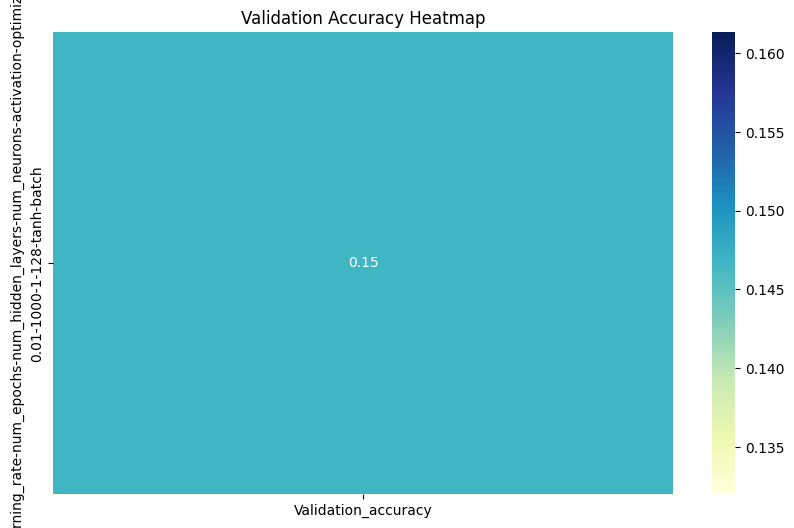

Hyperparameters for the Best Model:
learning_rate: 0.01
num_epochs: 1000
num_hidden_layers: 1
num_neurons: 128
activation: tanh
optimizer: batch
+---------------+------------------+-------------------------+-------------------+---------------------+-----------+---------------------+--------------------+--------------------+--------------------+---------------------+
| Learning Rate | Number of Epochs | Number of Hidden Layers | Number of Neurons | Activation Function | Optimizer |       Accuracy      |      F1 Score      |     Precision      |       Recall       |     Hamming Loss    |
+---------------+------------------+-------------------------+-------------------+---------------------+-----------+---------------------+--------------------+--------------------+--------------------+---------------------+
|      0.01     |       1000       |            1            |        128        |         tanh        |   batch   | 0.14666666666666667 | 0.5589204176517341 | 0.9339567297524433 | 0.

Loss Optimizer=batch Epochs=1000 Learning Rate=0.01 Num_hidden_layers=1 Num_neurons=128 Activation=tanh,█████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▁▁▁
Train_accuracy Learning Rate=0.01 Num_hidden_layers=1 Num_neurons=128 Activation=tanh,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▆▆▇▇███████████
Validation_accuracy Learning Rate=0.01 Num_hidden_layers=1 Num_neurons=128 Activation=tanh,▁
Loss Optimizer=batch Epochs=1000 Learning Rate=0.01 Num_hidden_layers=1 Num_neurons=128 Activation=tanh,4.21742
Train_accuracy Learning Rate=0.01 Num_hidden_layers=1 Num_neurons=128 Activation=tanh,0.12143
Validation_accuracy Learning Rate=0.01 Num_hidden_layers=1 Num_neurons=128 Activation=tanh,0.14667


In [19]:
# from itertools import product
# from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report,hamming_loss
# import matplotlib.pyplot as plt
# import pandas as pd
# import seaborn as sns
# from prettytable import PrettyTable
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# import numpy as np
# import wandb

# # Load and preprocess the data
# df = pd.read_csv('../../data/external/advertisement.csv')
# df = df.drop('city', axis=1)
# X = pd.get_dummies(df.drop('labels', axis=1), columns=['gender', 'education', 'married', 'occupation', 'most bought item'])
# X = np.array(X).astype(float)
# y = df['labels']

# # Process the labels into a suitable format for multilabel classification
# y = y.str.split()  # Split labels into lists of labels
# unique_labels = set(label for labels in y for label in labels)
# label_to_index = {label: i for i, label in enumerate(unique_labels)}

# # Map labels to binary format
# y_binary = np.zeros((len(y), len(unique_labels)), dtype=int)
# for i, labels in enumerate(y):
#     for label in labels:
#         y_binary[i, label_to_index[label]] = 1

# # Split the data into training, validation, and testing sets
# X_train, X_temp, y_train, y_temp = train_test_split(X, y_binary, test_size=0.3, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# scaler = StandardScaler()
# X_train_standardized = scaler.fit_transform(X_train)
# X_val_standardized = scaler.transform(X_val)
# X_test_standardized = scaler.transform(X_test)

# # Initialize W&B
# wandb.init(project='q2_4_bestparameters', entity='vishnuvarun-iiit-hyderabad')
# best_accuracy = 0
# best_model = None
# best_hyperparameters = None

# # Define hyperparameters to tune
# learning_rates = [0.01]
# num_epochs = [ 1000]
# num_hidden_layers = [1]
# num_neurons = [128]
# activations = ['tanh']
# optimizers = [ 'batch']
# # learning_rates = [0.01]
# # num_epochs = [100]
# # num_hidden_layers = [2]
# # num_neurons = [5]
# # activations = ['sigmoid']
# # optimizers = ['mini_batch_gradient_descent']


# # Hyperparameters for the Best Model:
# # learning_rate: 0.01
# # num_epochs: 1000
# # num_hidden_layers: 1
# # num_neurons: 128
# # activation: tanh
# # optimizer: batch
# metrics_table = PrettyTable()
# metrics_table.field_names = ["Learning Rate", "Number of Epochs", "Number of Hidden Layers", "Number of Neurons", "Activation Function", "Optimizer", "Accuracy", "F1 Score", "Precision", "Recall"]

# # Initialize a dictionary to collect metrics and hyperparameters
# hyperparameter_metrics = {
#     'learning_rate': [],
#     'num_epochs': [],
#     'num_hidden_layers': [],
#     'num_neurons': [],
#     'activation': [],
#     'optimizer': [],
#     'Validation_accuracy': [],
# }

# # Perform hyperparameter tuning
# for lr, epochs, num_layers, num_neurons, activation, optimizer in product(learning_rates, num_epochs, num_hidden_layers, num_neurons, activations, optimizers):
    
#     config = {
#         'learning_rate': lr,
#         'num_epochs': epochs,
#         'num_hidden_layers': num_layers,
#         'num_neurons': num_neurons,
#         'activation': activation,
#         'optimizer': optimizer
#     }
#     wandb.config.update(config)

#     model = MLPClassifierMultilabel(
#         num_hidden_layers=num_layers,
#         num_neurons=num_neurons,
#         activation=activation,
#         learning_rate=lr,
#         num_classes=len(unique_labels)
#     )
    
#     # Use the fit method with the specified optimizer
#     model.fit(X_train_standardized, y_train, optimizer=optimizer, num_epochs=epochs)
#     model.evaluate_model(X_val_standardized, y_val, isTrain=False)
#     y_pred_val = model.predict(X_val_standardized)
    
#     # Calculate and report metrics
#     accuracy = accuracy_score(y_val, y_pred_val)
#     f1 = f1_score(y_val, y_pred_val, average='weighted', zero_division=1) 
#     precision = precision_score(y_val, y_pred_val, average='weighted', zero_division=1)
#     recall = recall_score(y_val, y_pred_val, average='weighted', zero_division=1)
#     hamming_loss_val = hamming_loss(y_val, y_pred_val)
#     if accuracy > best_accuracy:
#         best_accuracy = accuracy
#         best_model = model
#         best_hyperparameters = {
#             'learning_rate': lr,
#             'num_epochs': epochs,
#             'num_hidden_layers': num_layers,
#             'num_neurons': num_neurons,
#             'activation': activation,
#             'optimizer': optimizer
#         }
        
#     metrics_table.add_row([lr, epochs, num_layers, num_neurons, activation, optimizer, accuracy, f1, precision, recall])
    
#     hyperparameter_metrics['learning_rate'].append(lr)
#     hyperparameter_metrics['num_epochs'].append(epochs)
#     hyperparameter_metrics['num_hidden_layers'].append(num_layers)
#     hyperparameter_metrics['num_neurons'].append(num_neurons)
#     hyperparameter_metrics['activation'].append(activation)
#     hyperparameter_metrics['optimizer'].append(optimizer)
#     hyperparameter_metrics['Validation_accuracy'].append(accuracy)

# df_metrics = pd.DataFrame(hyperparameter_metrics)
# hyperparameters = ['learning_rate', 'num_epochs', 'num_hidden_layers', 'num_neurons', 'activation', 'optimizer']

# # Create a pivot table for the heatmap
# pivot_table = df_metrics.pivot_table(index=hyperparameters, values='Validation_accuracy', aggfunc='mean')

# # Create a heatmap
# plt.figure(figsize=(10, 6))
# sns.heatmap(pivot_table, annot=True, cmap='YlGnBu')
# plt.title('Validation Accuracy Heatmap')
# plt.show()

# print("Hyperparameters for the Best Model:")
# for param, value in best_hyperparameters.items():
#     print(f"{param}: {value}")

# print(metrics_table)

# y_pred_test = best_model.predict(X_test_standardized)
# report = classification_report(y_test, y_pred_test, zero_division=1)
# print("Classification Report on Test Set:")
# print(report)

# # Finish the W&B run
# wandb.run.finish()
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, hamming_loss
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import wandb

# Load and preprocess the data
df = pd.read_csv('../../data/external/advertisement.csv')
df = df.drop('city', axis=1)
X = pd.get_dummies(df.drop('labels', axis=1), columns=['gender', 'education', 'married', 'occupation', 'most bought item'])
X = np.array(X).astype(float)
y = df['labels']

# Process the labels into a suitable format for multilabel classification
y = y.str.split()  # Split labels into lists of labels
unique_labels = set(label for labels in y for label in labels)
label_to_index = {label: i for i, label in enumerate(unique_labels)}

# Map labels to binary format
y_binary = np.zeros((len(y), len(unique_labels)), dtype=int)
for i, labels in enumerate(y):
    for label in labels:
        y_binary[i, label_to_index[label]] = 1

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_binary, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_val_standardized = scaler.transform(X_val)
X_test_standardized = scaler.transform(X_test)

# Initialize W&B
wandb.init(project='q2_4_bestparameters', entity='vishnuvarun-iiit-hyderabad')
best_accuracy = 0
best_model = None
best_hyperparameters = None

# Define hyperparameters to tune
learning_rates = [0.01]
num_epochs = [1000]
num_hidden_layers = [1]
num_neurons = [128]
activations = ['tanh']
optimizers = ['batch']

metrics_table = PrettyTable()
metrics_table.field_names = ["Learning Rate", "Number of Epochs", "Number of Hidden Layers", "Number of Neurons", "Activation Function", "Optimizer", "Accuracy", "F1 Score", "Precision", "Recall", "Hamming Loss"]

# Initialize a dictionary to collect metrics and hyperparameters
hyperparameter_metrics = {
    'learning_rate': [],
    'num_epochs': [],
    'num_hidden_layers': [],
    'num_neurons': [],
    'activation': [],
    'optimizer': [],
    'Validation_accuracy': [],
}

# Perform hyperparameter tuning
for lr, epochs, num_layers, num_neurons, activation, optimizer in product(learning_rates, num_epochs, num_hidden_layers, num_neurons, activations, optimizers):
    
    config = {
        'learning_rate': lr,
        'num_epochs': epochs,
        'num_hidden_layers': num_layers,
        'num_neurons': num_neurons,
        'activation': activation,
        'optimizer': optimizer
    }
    wandb.config.update(config)

    model = MLPClassifierMultilabel(
        num_hidden_layers=num_layers,
        num_neurons=num_neurons,
        activation=activation,
        learning_rate=lr,
        num_classes=len(unique_labels)
    )
    
    # Use the fit method with the specified optimizer
    model.fit(X_train_standardized, y_train, optimizer=optimizer, num_epochs=epochs)
    model.evaluate_model(X_val_standardized, y_val, isTrain=False)
    y_pred_val = model.predict(X_val_standardized)
    
    # Calculate and report metrics
    accuracy = accuracy_score(y_val, y_pred_val)
    f1 = f1_score(y_val, y_pred_val, average='weighted', zero_division=1) 
    precision = precision_score(y_val, y_pred_val, average='weighted', zero_division=1)
    recall = recall_score(y_val, y_pred_val, average='weighted', zero_division=1)
    hamming_loss_val = hamming_loss(y_val, y_pred_val)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_hyperparameters = {
            'learning_rate': lr,
            'num_epochs': epochs,
            'num_hidden_layers': num_layers,
            'num_neurons': num_neurons,
            'activation': activation,
            'optimizer': optimizer
        }
        
    metrics_table.add_row([lr, epochs, num_layers, num_neurons, activation, optimizer, accuracy, f1, precision, recall, hamming_loss_val])
    
    hyperparameter_metrics['learning_rate'].append(lr)
    hyperparameter_metrics['num_epochs'].append(epochs)
    hyperparameter_metrics['num_hidden_layers'].append(num_layers)
    hyperparameter_metrics['num_neurons'].append(num_neurons)
    hyperparameter_metrics['activation'].append(activation)
    hyperparameter_metrics['optimizer'].append(optimizer)
    hyperparameter_metrics['Validation_accuracy'].append(accuracy)

df_metrics = pd.DataFrame(hyperparameter_metrics)
hyperparameters = ['learning_rate', 'num_epochs', 'num_hidden_layers', 'num_neurons', 'activation', 'optimizer']

# Create a pivot table for the heatmap
pivot_table = df_metrics.pivot_table(index=hyperparameters, values='Validation_accuracy', aggfunc='mean')

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu')
plt.title('Validation Accuracy Heatmap')
plt.show()

print("Hyperparameters for the Best Model:")
for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")

print(metrics_table)

# Evaluate on the test set
y_pred_test = best_model.predict(X_test_standardized)
accuracy_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test, average='weighted', zero_division=1)
precision_test = precision_score(y_test, y_pred_test, average='weighted', zero_division=1)
recall_test = recall_score(y_test, y_pred_test, average='weighted', zero_division=1)
hamming_loss_test = hamming_loss(y_test, y_pred_test)

print("Classification Report on Test Set:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"F1 Score: {f1_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"Hamming Loss: {hamming_loss_test:.4f}")

# Evaluate on the validation set
accuracy_val = accuracy_score(y_val, y_pred_val)
f1_val = f1_score(y_val, y_pred_val, average='weighted', zero_division=1)
precision_val = precision_score(y_val, y_pred_val, average='weighted', zero_division=1)
recall_val = recall_score(y_val, y_pred_val, average='weighted', zero_division=1)
hamming_loss_val = hamming_loss(y_val, y_pred_val)

print("Classification Report on Validation Set:")
print(f"Accuracy: {accuracy_val:.4f}")
print(f"F1 Score: {f1_val:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"Recall: {recall_val:.4f}")
print(f"Hamming Loss: {hamming_loss_val:.4f}")

# Finish the W&B run
wandb.run.finish()


Batch Epoch 100/1000, Loss: 5.3899
Batch Epoch 200/1000, Loss: 5.2845
Batch Epoch 300/1000, Loss: 5.2007
Batch Epoch 400/1000, Loss: 5.1166
Batch Epoch 500/1000, Loss: 5.0137
Batch Epoch 600/1000, Loss: 4.8787
Batch Epoch 700/1000, Loss: 4.7117
Batch Epoch 800/1000, Loss: 4.5312
Batch Epoch 900/1000, Loss: 4.3632
Batch Epoch 1000/1000, Loss: 4.2250
Batch Training complete!


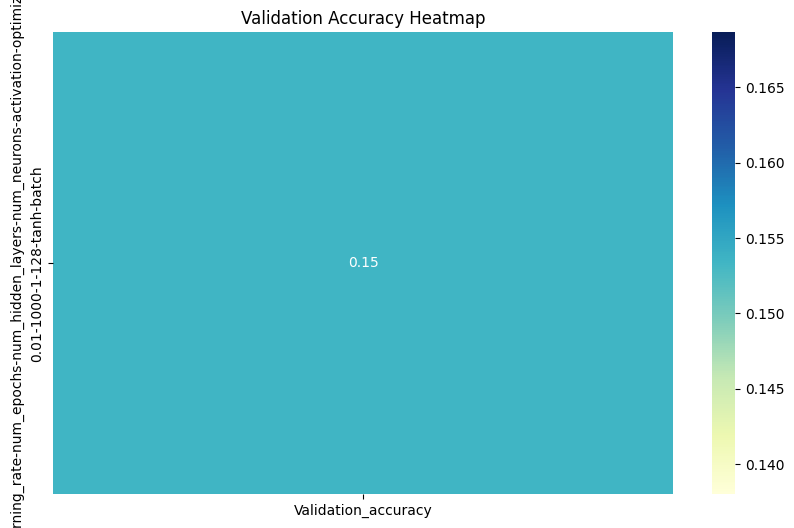

Hyperparameters for the Best Model:
learning_rate: 0.01
num_epochs: 1000
num_hidden_layers: 1
num_neurons: 128
activation: tanh
optimizer: batch
+---------------+------------------+-------------------------+-------------------+---------------------+-----------+---------------------+--------------------+--------------------+--------------------+---------------------+
| Learning Rate | Number of Epochs | Number of Hidden Layers | Number of Neurons | Activation Function | Optimizer |       Accuracy      |      F1 Score      |     Precision      |       Recall       |     Hamming Loss    |
+---------------+------------------+-------------------------+-------------------+---------------------+-----------+---------------------+--------------------+--------------------+--------------------+---------------------+
|      0.01     |       1000       |            1            |        128        |         tanh        |   batch   | 0.15333333333333332 | 0.5592008203317791 | 0.9365905504908835 | 0.

Loss Optimizer=batch Epochs=1000 Learning Rate=0.01 Num_hidden_layers=1 Num_neurons=128 Activation=tanh,█▇▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
Train_accuracy Learning Rate=0.01 Num_hidden_layers=1 Num_neurons=128 Activation=tanh,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▄▅▅▇▇██████
Validation_accuracy Learning Rate=0.01 Num_hidden_layers=1 Num_neurons=128 Activation=tanh,▁
Loss Optimizer=batch Epochs=1000 Learning Rate=0.01 Num_hidden_layers=1 Num_neurons=128 Activation=tanh,4.22505
Train_accuracy Learning Rate=0.01 Num_hidden_layers=1 Num_neurons=128 Activation=tanh,0.12571
Validation_accuracy Learning Rate=0.01 Num_hidden_layers=1 Num_neurons=128 Activation=tanh,0.15333


In [21]:
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, hamming_loss
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import wandb

# Load and preprocess the data
df = pd.read_csv('../../data/external/advertisement.csv')
df = df.drop('city', axis=1)
X = pd.get_dummies(df.drop('labels', axis=1), columns=['gender', 'education', 'married', 'occupation', 'most bought item'])
X = np.array(X).astype(float)
y = df['labels']

# Process the labels into a suitable format for multilabel classification
y = y.str.split()  # Split labels into lists of labels
unique_labels = set(label for labels in y for label in labels)
label_to_index = {label: i for i, label in enumerate(unique_labels)}

# Map labels to binary format
y_binary = np.zeros((len(y), len(unique_labels)), dtype=int)
for i, labels in enumerate(y):
    for label in labels:
        y_binary[i, label_to_index[label]] = 1

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_binary, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_val_standardized = scaler.transform(X_val)
X_test_standardized = scaler.transform(X_test)

# Initialize W&B
wandb.init(project='q2_final4_test_best', entity='vishnuvarun-iiit-hyderabad')
best_accuracy = 0
best_model = None
best_hyperparameters = None

# Define hyperparameters to tune
learning_rates = [0.01]
num_epochs = [1000]
num_hidden_layers = [1]
num_neurons = [128]
activations = ['tanh']
optimizers = ['batch']

metrics_table = PrettyTable()
metrics_table.field_names = ["Learning Rate", "Number of Epochs", "Number of Hidden Layers", "Number of Neurons", "Activation Function", "Optimizer", "Accuracy", "F1 Score", "Precision", "Recall", "Hamming Loss"]

# Initialize a dictionary to collect metrics and hyperparameters
hyperparameter_metrics = {
    'learning_rate': [],
    'num_epochs': [],
    'num_hidden_layers': [],
    'num_neurons': [],
    'activation': [],
    'optimizer': [],
    'Validation_accuracy': [],
}

# Perform hyperparameter tuning
for lr, epochs, num_layers, num_neurons, activation, optimizer in product(learning_rates, num_epochs, num_hidden_layers, num_neurons, activations, optimizers):
    
    config = {
        'learning_rate': lr,
        'num_epochs': epochs,
        'num_hidden_layers': num_layers,
        'num_neurons': num_neurons,
        'activation': activation,
        'optimizer': optimizer
    }
    wandb.config.update(config)

    model = MLPClassifierMultilabel(
        num_hidden_layers=num_layers,
        num_neurons=num_neurons,
        activation=activation,
        learning_rate=lr,
        num_classes=len(unique_labels)
    )
    
    # Use the fit method with the specified optimizer
    model.fit(X_train_standardized, y_train, optimizer=optimizer, num_epochs=epochs)
    model.evaluate_model(X_val_standardized, y_val, isTrain=False)
    y_pred_val = model.predict(X_val_standardized)
    
    # Calculate and report metrics
    accuracy = accuracy_score(y_val, y_pred_val)
    f1 = f1_score(y_val, y_pred_val, average='weighted', zero_division=1) 
    precision = precision_score(y_val, y_pred_val, average='weighted', zero_division=1)
    recall = recall_score(y_val, y_pred_val, average='weighted', zero_division=1)
    hamming_loss_val = hamming_loss(y_val, y_pred_val)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_hyperparameters = {
            'learning_rate': lr,
            'num_epochs': epochs,
            'num_hidden_layers': num_layers,
            'num_neurons': num_neurons,
            'activation': activation,
            'optimizer': optimizer
        }
        
    metrics_table.add_row([lr, epochs, num_layers, num_neurons, activation, optimizer, accuracy, f1, precision, recall, hamming_loss_val])
    
    hyperparameter_metrics['learning_rate'].append(lr)
    hyperparameter_metrics['num_epochs'].append(epochs)
    hyperparameter_metrics['num_hidden_layers'].append(num_layers)
    hyperparameter_metrics['num_neurons'].append(num_neurons)
    hyperparameter_metrics['activation'].append(activation)
    hyperparameter_metrics['optimizer'].append(optimizer)
    hyperparameter_metrics['Validation_accuracy'].append(accuracy)

df_metrics = pd.DataFrame(hyperparameter_metrics)
hyperparameters = ['learning_rate', 'num_epochs', 'num_hidden_layers', 'num_neurons', 'activation', 'optimizer']

# Create a pivot table for the heatmap
pivot_table = df_metrics.pivot_table(index=hyperparameters, values='Validation_accuracy', aggfunc='mean')

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu')
plt.title('Validation Accuracy Heatmap')
plt.show()

print("Hyperparameters for the Best Model:")
for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")

print(metrics_table)

# Evaluate on the test set
y_pred_test = best_model.predict(X_test_standardized)
accuracy_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test, average='weighted', zero_division=1)
precision_test = precision_score(y_test, y_pred_test, average='weighted', zero_division=1)
recall_test = recall_score(y_test, y_pred_test, average='weighted', zero_division=1)
hamming_loss_test = hamming_loss(y_test, y_pred_test)

print("Classification Report on Test Set:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"F1 Score: {f1_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"Hamming Loss: {hamming_loss_test:.4f}")

# Evaluate on the validation set
accuracy_val = accuracy_score(y_val, y_pred_val)
f1_val = f1_score(y_val, y_pred_val, average='weighted', zero_division=1)
precision_val = precision_score(y_val, y_pred_val, average='weighted', zero_division=1)
recall_val = recall_score(y_val, y_pred_val, average='weighted', zero_division=1)
hamming_loss_val = hamming_loss(y_val, y_pred_val)

print("Classification Report on Validation Set:")
print(f"Accuracy: {accuracy_val:.4f}")
print(f"F1 Score: {f1_val:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"Recall: {recall_val:.4f}")
print(f"Hamming Loss: {hamming_loss_val:.4f}")

# Class-wise analysis function
def analyze_classification_performance_ml(y_true, y_pred, class_labels):
    class_metrics = {}
    for i, label in enumerate(class_labels):
        true_class = y_true[:, i]
        pred_class = y_pred[:, i]
        
        accuracy = accuracy_score(true_class, pred_class)
        f1 = f1_score(true_class, pred_class, zero_division=1)
        precision = precision_score(true_class, pred_class, zero_division=1)
        recall = recall_score(true_class, pred_class, zero_division=1)
        
        class_metrics[label] = {
            'accuracy': accuracy,
            'f1_score': f1,
            'precision': precision,
            'recall': recall
        }
    
    for label, metrics in class_metrics.items():
        print(f"Class: {label}")
        print(f"  Accuracy: {metrics['accuracy']:.4f}")
        print(f"  F1 Score: {metrics['f1_score']:.4f}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall: {metrics['recall']:.4f}")
        print()

# Class-wise analysis for validation set
print("\nClass-wise Analysis on Validation Set:")
analyze_classification_performance_ml(y_val, y_pred_val, list(unique_labels))

# Class-wise analysis for test set
print("\nClass-wise Analysis on Test Set:")
analyze_classification_performance_ml(y_test, y_pred_test, list(unique_labels))

# Finish the W&B run
wandb.run.finish()

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import sys
# import os
# # Adding the parent directory to the Python path
# current_dir = os.path.dirname(os.path.abspath(__file__))
# parent_dir = os.path.dirname(os.path.dirname(current_dir))
# sys.path.append(parent_dir)
# # import seaborn as sns
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from itertools import product
# import wandb
# from models.MLP.MLP import MLPClassifier



# def load_and_preprocess_data(file_path):
#     data = pd.read_csv(file_path)
    
#     # 1. Describe the dataset
#     print(data.describe())
    
#     # 2. Plot distribution of quality labels
#     plt.figure(figsize=(10, 6))
#     sns.countplot(x='quality', data=data)
#     plt.title('Distribution of Wine Quality')
#     plt.savefig('figures/2/2_1/distribution_of_wine_quality.png')
#     plt.show()
    
#     # 3. Normalize and standardize data
#     X = data.drop('quality', axis=1)
#     y = data['quality']
    
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X)
    
#     # One-hot encode the target variable
#     y_encoded = pd.get_dummies(y).values
    
#     return X_scaled, y_encoded

# from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# def evaluate_model(y_true, y_pred):
#     accuracy = accuracy_score(y_true, y_pred)
#     f1 = f1_score(y_true, y_pred, average='weighted')
#     precision = precision_score(y_true, y_pred, average='weighted')
#     recall = recall_score(y_true, y_pred, average='weighted')
    
#     return accuracy, f1, precision, recall
# def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, config):
#     model = MLPClassifier(
#         input_size=X_train.shape[1],
#         hidden_sizes=config['hidden_sizes'],
#         output_size=y_train.shape[1],
#         activation=config['activation'],
#         learning_rate=config['learning_rate'],
#         epochs=config['epochs'],
#         batch_size=config['batch_size'],
#         optimizer=config['optimizer']
#     )
    
#     model.fit(X_train, y_train, X_val, y_val)
    
#     y_pred = model.predict(X_test)
#     y_true = np.argmax(y_test, axis=1)
    
#     accuracy, f1, precision, recall = evaluate_model(y_true, y_pred)
    
#     return model, accuracy, f1, precision, recall



# def accuracy_score(y_true, y_pred):
#     return np.mean(y_true == y_pred)

# def precision_score(y_true, y_pred, average='weighted'):
#     unique_classes = np.unique(y_true)
#     precisions = []
#     for cls in unique_classes:
#         true_positive = np.sum((y_true == cls) & (y_pred == cls))
#         predicted_positive = np.sum(y_pred == cls)
#         precision = true_positive / predicted_positive if predicted_positive > 0 else 0
#         precisions.append(precision)
#     if average == 'weighted':
#         weights = [np.sum(y_true == cls) for cls in unique_classes]
#         return np.average(precisions, weights=weights)
#     return np.mean(precisions)

# def recall_score(y_true, y_pred, average='weighted'):
#     unique_classes = np.unique(y_true)
#     recalls = []
#     for cls in unique_classes:
#         true_positive = np.sum((y_true == cls) & (y_pred == cls))
#         actual_positive = np.sum(y_true == cls)
#         recall = true_positive / actual_positive if actual_positive > 0 else 0
#         recalls.append(recall)
#     if average == 'weighted':
#         weights = [np.sum(y_true == cls) for cls in unique_classes]
#         return np.average(recalls, weights=weights)
#     return np.mean(recalls)

# def f1_score(y_true, y_pred, average='weighted'):
#     precisions = precision_score(y_true, y_pred, average=None)
#     recalls = recall_score(y_true, y_pred, average=None)
#     f1s = []
#     for p, r in zip(precisions, recalls):
#         f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0
#         f1s.append(f1)
#     if average == 'weighted':
#         weights = [np.sum(y_true == cls) for cls in np.unique(y_true)]
#         return np.average(f1s, weights=weights)
#     return np.mean(f1s)

# def evaluate_model(y_true, y_pred):
#     accuracy = accuracy_score(y_true, y_pred)
#     f1 = f1_score(y_true, y_pred, average='weighted')
#     precision = precision_score(y_true, y_pred, average='weighted')
#     recall = recall_score(y_true, y_pred, average='weighted')
    
#     return accuracy, f1, precision, recall



# def hyperparameter_tuning(X_train, y_train, X_val, y_val, X_test, y_test):
#     # Define hyperparameters to tune
#     hidden_sizes_list = [[64, 32], [128, 64], [256, 128]]
#     activations = ['sigmoid', 'tanh', 'relu']
#     learning_rates = [0.0001, 0.001, 0.01]
#     epochs_list = [100, 500, 1000]
#     batch_sizes = [16, 32, 64]
#     optimizers = ['sgd', 'batch', 'mini-batch']

#     best_model = None
#     best_accuracy = 0
#     best_config = None

#     wandb.init(project='q2_1', entity='vishnuvarun-iiit-hyderabad')

#     for hidden_sizes, activation, lr, epochs, batch_size, optimizer in product(hidden_sizes_list, activations, learning_rates, epochs_list, batch_sizes, optimizers):
#         config = {
#             'hidden_sizes': hidden_sizes,
#             'activation': activation,
#             'learning_rate': lr,
#             'epochs': epochs,
#             'batch_size': batch_size,
#             'optimizer': optimizer
#         }
        
#         print(f"Testing configuration: {config}")
        
#         model, accuracy, f1, precision, recall = train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, config)
        
#         wandb.log({
#             "accuracy": accuracy,
#             "f1_score": f1,
#             "precision": precision,
#             "recall": recall
#         })
        
#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             best_model = model
#             best_config = config

#     print("Best Model Configuration:")
#     print(best_config)
#     wandb.finish()
#     return best_model

# def evaluate_best_model(X_test_standardized, y_test, X_val_standardized, y_val, best_model):
#     print("Best Model Parameters:")
#     print(f"Hidden Sizes: {best_model.hidden_sizes}")
#     print(f"Activation Function: {best_model.activation}")
#     print(f"Learning Rate: {best_model.learning_rate}")
#     print(f"Optimizer: {best_model.optimizer}")
#     print(f"Batch Size: {best_model.batch_size}")
#     print(f"Number of Epochs: {best_model.epochs}")
    
#     # Evaluate on validation set
#     y_pred_val = best_model.predict(X_val_standardized)
#     y_true_val = np.argmax(y_val, axis=1)
    
#     val_accuracy, val_f1, val_precision, val_recall = evaluate_model(y_true_val, y_pred_val)
    
#     print("\nValidation Set Metrics:")
#     print(f"Validation Accuracy: {val_accuracy:.4f}")
#     print(f"Validation F1 Score: {val_f1:.4f}")
#     print(f"Validation Precision: {val_precision:.4f}")
#     print(f"Validation Recall: {val_recall:.4f}")
    
#     # Evaluate on test set
#     y_pred_test = best_model.predict(X_test_standardized)
#     y_true_test = np.argmax(y_test, axis=1)
    
#     test_accuracy, test_f1, test_precision, test_recall = evaluate_model(y_true_test, y_pred_test)
    
#     print("\nTest Set Metrics:")
#     print(f"Test Accuracy: {test_accuracy:.4f}")
#     print(f"Test F1 Score: {test_f1:.4f}")
#     print(f"Test Precision: {test_precision:.4f}")
#     print(f"Test Recall: {test_recall:.4f}")

# def analyze_hyperparameters(X_train, y_train, X_val, y_val):
#     # Effect of Non-linearity
#     activations = ['sigmoid', 'tanh', 'relu', 'linear']
#     plt.figure(figsize=(12, 8))
#     for activation in activations:
#         model = MLPClassifier(input_size=X_train.shape[1], hidden_sizes=[256, 128], output_size=y_train.shape[1],
#                               activation=activation, learning_rate=0.001, epochs=500, batch_size=16)
#         model.fit(X_train, y_train, X_val, y_val)
#         plt.plot(model.val_losses, label=activation)
#     plt.title('Effect of Activation Functions')
#     plt.xlabel('Epochs')
#     plt.ylabel('Validation Loss')
#     plt.legend()
#     plt.savefig('figures/2/2_5/earlystopping/effect_of_activation_functions.png')
#     plt.show()
    
#     # Effect of Learning Rate
#     learning_rates = [0.0001, 0.001, 0.01, 0.1]
#     plt.figure(figsize=(12, 8))
#     for lr in learning_rates:
#         model = MLPClassifier(input_size=X_train.shape[1], hidden_sizes=[256, 128], output_size=y_train.shape[1],
#                               activation='relu', learning_rate=lr, epochs=500, batch_size=16)
#         model.fit(X_train, y_train, X_val, y_val)
#         plt.plot(model.val_losses, label=f'LR: {lr}')
#     plt.title('Effect of Learning Rate')
#     plt.xlabel('Epochs')
#     plt.ylabel('Validation Loss')
#     plt.legend()
#     plt.savefig('figures/2/2_5/earlystopping/effect_of_learning_rate.png')
#     plt.show()
    
#     # Effect of Batch Size
#     batch_sizes = [16, 32, 64, 128]
#     plt.figure(figsize=(12, 8))
#     for bs in batch_sizes:
#         model = MLPClassifier(input_size=X_train.shape[1], hidden_sizes=[256, 128], output_size=y_train.shape[1],
#                               activation='relu', learning_rate=0.001, epochs=500, batch_size=bs, optimizer='mini-batch')
#         model.fit(X_train, y_train, X_val, y_val)
#         plt.plot(model.val_losses, label=f'Batch Size: {bs}')
#     plt.title('Effect of Batch Size')
#     plt.xlabel('Epochs')
#     plt.ylabel('Validation Loss')
#     plt.legend()
#     plt.savefig('figures/2/2_5/earlystopping/effect_of_batch_size.png')
#     plt.show()
    
# def analyze_hyperparameters_without_earlystopping(X_train, y_train, X_val, y_val):
#     # Effect of Non-linearity
#     activations = ['sigmoid', 'tanh', 'relu', 'linear']
#     plt.figure(figsize=(12, 8))
#     for activation in activations:
#         model = MLPClassifier(input_size=X_train.shape[1], hidden_sizes=[256, 128], output_size=y_train.shape[1],
#                               activation=activation, learning_rate=0.001, epochs=500, batch_size=16,early_stopping=False)
#         model.fit(X_train, y_train, X_val, y_val)
#         plt.plot(model.val_losses, label=activation)
#     plt.title('Effect of Activation Functions')
#     plt.xlabel('Epochs')
#     plt.ylabel('Validation Loss')
#     plt.legend()
#     plt.savefig('figures/2/2_5/withoutearlystopping/effect_of_activation_functions.png')
#     plt.show()
    
#     # Effect of Learning Rate
#     learning_rates = [0.0001, 0.001, 0.01, 0.1]
#     plt.figure(figsize=(12, 8))
#     for lr in learning_rates:
#         model = MLPClassifier(input_size=X_train.shape[1], hidden_sizes=[256, 128], output_size=y_train.shape[1],
#                               activation='relu', learning_rate=lr, epochs=500, batch_size=16,early_stopping=False)
#         model.fit(X_train, y_train, X_val, y_val)
#         plt.plot(model.val_losses, label=f'LR: {lr}')
#     plt.title('Effect of Learning Rate')
#     plt.xlabel('Epochs')
#     plt.ylabel('Validation Loss')
#     plt.legend()
#     plt.savefig('figures/2/2_5/withoutearlystopping/effect_of_learning_rate.png')
#     plt.show()
    
#     # Effect of Batch Size
#     batch_sizes = [16, 32, 64, 128]
#     plt.figure(figsize=(12, 8))
#     for bs in batch_sizes:
#         model = MLPClassifier(input_size=X_train.shape[1], hidden_sizes=[256, 128], output_size=y_train.shape[1],
#                               activation='relu', learning_rate=0.001, epochs=500, batch_size=bs, optimizer='mini-batch',early_stopping=False)
#         model.fit(X_train, y_train, X_val, y_val)
#         plt.plot(model.val_losses, label=f'Batch Size: {bs}')
#     plt.title('Effect of Batch Size')
#     plt.xlabel('Epochs')
#     plt.ylabel('Validation Loss')
#     plt.legend()
#     plt.savefig('figures/2/2_5/withoutearlystopping/effect_of_batch_size.png')
#     plt.show()


# if __name__ == "__main__":
#     # Load and preprocess the data
#     file_path = '../../data/external/WineQT.csv'  # Update with the correct path to your dataset
#     X_scaled, y_encoded = load_and_preprocess_data(file_path)

#     # Split the data into train, validation, and test sets
#     X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)
#     X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#     # Define a configuration for the model
#     config = {
#         'hidden_sizes': [256, 128],
#         'activation': 'relu',
#         'learning_rate': 0.001,
#         'epochs': 500,
#         'batch_size': 16,
#         'optimizer': 'sgd'
#     }

#     # Train and evaluate the model
#     model, accuracy, f1, precision, recall = train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, config)
#     print(f"Accuracy: {accuracy:.4f}")
#     print(f"F1 Score: {f1:.4f}")
#     print(f"Precision: {precision:.4f}")
#     print(f"Recall: {recall:.4f}")

#     #Perform hyperparameter tuning
#     best_model = hyperparameter_tuning(X_train, y_train, X_val, y_val, X_test, y_test)

#     # Evaluate best model
#     evaluate_best_model(X_test, y_test, X_val, y_val, best_model)

#     # Analyze hyperparameters
#     analyze_hyperparameters(X_train, y_train, X_val, y_val)
    
#     #Analyze hyperparameters without early stopping
#     analyze_hyperparameters_without_earlystopping(X_train, y_train, X_val, y_val)

# Call the main function
MLPClassifier_main()


In [ ]:



####-----MULTILABEL CLASSIFICATION-----####

from models.MLP.MLP import MultiLabelMLPClassifier
# from performance_measures.metrics import accuracy_score, f1_score, precision_score, recall_score, hamming_loss
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, hamming_loss
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    
    # Drop the 'city' column as it's not needed
    data = data.drop('city', axis=1)

    # One-hot encode categorical features
    X = pd.get_dummies(data.drop('labels', axis=1), columns=['gender', 'education', 'married', 'occupation', 'most bought item'])
    X = np.array(X).astype(float)

    # Process the labels into a suitable format for multi-label classification
    y = data['labels'].str.split()  # Split labels into lists of labels
    unique_labels = set(label for labels in y for label in labels)
    label_to_index = {label: i for i, label in enumerate(unique_labels)}

    # Map labels to binary format
    y_binary = np.zeros((len(y), len(unique_labels)), dtype=int)
    for i, labels in enumerate(y):
        for label in labels:
            y_binary[i, label_to_index[label]] = 1

    # Split the data into training, validation, and testing sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y_binary, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Standardize the data
    scaler = StandardScaler()
    X_train_standardized = scaler.fit_transform(X_train)
    X_val_standardized = scaler.transform(X_val)
    X_test_standardized = scaler.transform(X_test)

    return X_train_standardized, y_train, X_val_standardized, y_val, X_test_standardized, y_test

def train_and_evaluate_ml(X_train, y_train, X_val, y_val, X_test, y_test, config):
    model = MultiLabelMLPClassifier(
        input_size=X_train.shape[1],
        hidden_sizes=config['hidden_sizes'],
        output_size=y_train.shape[1],
        activation=config['activation'],
        learning_rate=config['learning_rate'],
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        optimizer=config['optimizer']
    )
    
    model.fit(X_train, y_train, X_val, y_val)
    
    y_pred = model.predict(X_test)
    y_true = y_test
    
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    hamming = hamming_loss(y_true, y_pred)
    
    return model, accuracy, f1, precision, recall, hamming

def hyperparameter_tuning_multilabel(X_train, y_train, X_val, y_val, X_test, y_test):
    # Define hyperparameters to tune
    # hidden_sizes_list = [[64, 32], [128, 64], [256, 128]]
    # activations = ['sigmoid', 'tanh', 'relu']
    # learning_rates = [0.0001, 0.001, 0.01]
    # epochs_list = [100, 500, 1000]
    # batch_sizes = [16, 32, 64]
    # optimizers = ['sgd', 'batch', 'mini-batch']
#     Hyperparameters for the Best Model:
# learning_rate: 0.01
# num_epochs: 1000
# num_hidden_layers: 1
# num_neurons: 128
# activation: tanh
# optimizer: batch

    hidden_sizes_list = [[128]]
    activations = ['tanh']
    learning_rates = [ 0.01]
    epochs_list = [1000]
    batch_sizes = [16, 32, 64]
    optimizers = ['batch']

    best_model = None
    best_accuracy = 0
    best_config = None

    wandb.init(project='q2_final4_best', entity='vishnuvarun-iiit-hyderabad')

    for hidden_sizes, activation, lr, epochs, batch_size, optimizer in product(hidden_sizes_list, activations, learning_rates, epochs_list, batch_sizes, optimizers):
        config = {
            'hidden_sizes': hidden_sizes,
            'activation': activation,
            'learning_rate': lr,
            'epochs': epochs,
            'batch_size': batch_size,
            'optimizer': optimizer
        }
        
        print(f"Testing configuration: {config}")
        
        model, accuracy, f1, precision, recall, hamming = train_and_evaluate_ml(X_train, y_train, X_val, y_val, X_test, y_test, config)
        
        wandb.log({
            "accuracy": accuracy,
            "f1_score": f1,
            "precision": precision,
            "recall": recall,
            "hamming_loss": hamming
        })
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
            best_config = config

    print("Best Model Configuration:")
    print(best_config)
    wandb.finish()
    return best_model

def evaluate_best_model_ml(X_test_standardized, y_test, X_val_standardized, y_val, best_model):
    print("Best Model Parameters:")
    print(f"Hidden Sizes: {best_model.hidden_sizes}")
    print(f"Activation Function: {best_model.activation}")
    print(f"Learning Rate: {best_model.learning_rate}")
    print(f"Optimizer: {best_model.optimizer}")
    print(f"Batch Size: {best_model.batch_size}")
    print(f"Number of Epochs: {best_model.epochs}")
    
    # Evaluate on validation set
    y_pred_val = best_model.predict(X_val_standardized)
    y_true_val = y_val
    
    val_accuracy = accuracy_score(y_true_val, y_pred_val)
    val_f1 = f1_score(y_true_val, y_pred_val, average='weighted')
    val_precision = precision_score(y_true_val, y_pred_val, average='weighted')
    val_recall = recall_score(y_true_val, y_pred_val, average='weighted')
    val_hamming = hamming_loss(y_true_val, y_pred_val)
    
    print("\nValidation Set Metrics:")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation F1 Score: {val_f1:.4f}")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Validation Hamming Loss: {val_hamming:.4f}")
    
    # Evaluate on test set
    y_pred_test = best_model.predict(X_test_standardized)
    y_true_test = y_test
    
    test_accuracy = accuracy_score(y_true_test, y_pred_test)
    test_f1 = f1_score(y_true_test, y_pred_test, average='weighted')
    test_precision = precision_score(y_true_test, y_pred_test, average='weighted')
    test_recall = recall_score(y_true_test, y_pred_test, average='weighted')
    test_hamming = hamming_loss(y_true_test, y_pred_test)
    
    print("\nTest Set Metrics:")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test Hamming Loss: {test_hamming:.4f}")

def analyze_classification_performance_ml(y_true, y_pred, class_labels):
    class_metrics = {}
    for i, label in enumerate(class_labels):
        true_class = y_true[:, i]
        pred_class = y_pred[:, i]
        
        accuracy = accuracy_score(true_class, pred_class)
        f1 = f1_score(true_class, pred_class)
        precision = precision_score(true_class, pred_class)
        recall = recall_score(true_class, pred_class)
        
        class_metrics[label] = {
            'accuracy': accuracy,
            'f1_score': f1,
            'precision': precision,
            'recall': recall
        }
    
    for label, metrics in class_metrics.items():
        print(f"Class: {label}")
        print(f"  Accuracy: {metrics['accuracy']:.4f}")
        print(f"  F1 Score: {metrics['f1_score']:.4f}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall: {metrics['recall']:.4f}")
        print()

if __name__ == "__main__":
    # Load and preprocess the data
    file_path = '../../data/external/advertisement.csv'  # Update with the correct path to your dataset
    X_train, y_train, X_val, y_val, X_test, y_test = load_and_preprocess_data(file_path)

    # Perform hyperparameter tuning
    best_model = hyperparameter_tuning_multilabel(X_train, y_train, X_val, y_val, X_test, y_test)

    # Evaluate best model
    evaluate_best_model_ml(X_test, y_test, X_val, y_val, best_model)

    # Analyze classification performance
    class_labels = list(set(label for labels in y_train for label in labels))
    y_pred = best_model.predict(X_test)
    analyze_classification_performance_ml(y_test, y_pred, class_labels)



In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.impute import SimpleImputer
# import numpy as np
# import wandb
# from itertools import product
# from models.MLP.MLP import MLPRegressor
# # from performance_measures.performance_measures import performance_measures as PerformanceMeasures
# from performance_measures.performance_measures import accuracy_score, mean_squared_error,root_mean_squared_error, mean_absolute_error, r_squared,precision_score,recall_score,f1_score,evaluate_model
# # Load the dataset and display basic statistics
# housing_data = pd.read_csv("../../data/external/HousingData.csv")
# stats_summary = housing_data.agg(['mean', 'std', 'min', 'max'])
# print(stats_summary)

# # Plot the distribution of the target variable (MEDV)
# medv_values = housing_data['MEDV']

# plt.figure(figsize=(8, 6))
# plt.hist(medv_values, bins=30, edgecolor='k', alpha=0.7)
# plt.xlabel('MEDV')
# plt.ylabel('Frequency')
# plt.title('Distribution of MEDV')
# plt.savefig('figures/3/MEDV_distribution.png')
# plt.show()

# # Split the dataset into training (70%), validation (15%), and test (15%) sets
# features = housing_data.drop(columns=['MEDV'])
# target = housing_data['MEDV']
# target = np.array(target).reshape(-1, 1)

# X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.3, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# # Handle missing values by imputing with the mean
# imputer = SimpleImputer(strategy='mean')
# X_train_imputed = imputer.fit_transform(X_train)
# X_val_imputed = imputer.transform(X_val)
# X_test_imputed = imputer.transform(X_test)

# # Normalize the features using Min-Max scaling
# min_max_scaler = MinMaxScaler()
# X_train_normalized = min_max_scaler.fit_transform(X_train_imputed)
# X_val_normalized = min_max_scaler.transform(X_val_imputed)
# X_test_normalized = min_max_scaler.transform(X_test_imputed)

# # Standardize the features to have mean=0 and std=1 using Z-score scaling
# standard_scaler = StandardScaler()
# X_train_standardized = standard_scaler.fit_transform(X_train_imputed)
# X_val_standardized = standard_scaler.transform(X_val_imputed)
# X_test_standardized = standard_scaler.transform(X_test_imputed)



# def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, config):
#     model = MLPRegressor(
#         input_size=X_train.shape[1],
#         hidden_sizes=config['hidden_sizes'],
#         output_size=1,
#         activation=config['activation'],
#         learning_rate=config['learning_rate'],
#         epochs=config['epochs'],
#         batch_size=config['batch_size'],
#         optimizer=config['optimizer']
#     )
    
#     model.fit(X_train, y_train, X_val, y_val)
    
#     y_pred = model.predict(X_test)
#     y_true = y_test
    
#     mse = mean_squared_error(y_true, y_pred)
#     rmse = root_mean_squared_error(y_true, y_pred)
#     r2 = r_squared(y_true, y_pred)
    
#     return model, mse, rmse, r2

# def hyperparameter_tuning(X_train_standardized, y_train, X_val_standardized, y_val, X_test_standardized, y_test):
#     # Define hyperparameters to tune
#     hidden_sizes_list = [[64, 32], [128, 64], [256, 128]]
#     activations = ['sigmoid', 'tanh', 'relu']
#     learning_rates = [0.0001, 0.001, 0.01]
#     epochs_list = [100, 500, 1000]
#     batch_sizes = [16, 32, 64]
#     optimizers = ['sgd', 'batch', 'mini-batch']

#     best_model = None
#     best_mse = float('inf')
#     best_config = None

#     wandb.init(project='regression_test_prefinal', entity='vishnuvarun-iiit-hyderabad')

#     for hidden_sizes, activation, lr, epochs, batch_size, optimizer in product(hidden_sizes_list, activations, learning_rates, epochs_list, batch_sizes, optimizers):
#         config = {
#             'hidden_sizes': hidden_sizes,
#             'activation': activation,
#             'learning_rate': lr,
#             'epochs': epochs,
#             'batch_size': batch_size,
#             'optimizer': optimizer
#         }
        
#         print(f"Testing configuration: {config}")
        
#         model, mse, rmse, r2 = train_and_evaluate(X_train_standardized, y_train, X_val_standardized, y_val, X_test_standardized, y_test, config)
        
#         wandb.log({
#             "mse": mse,
#             "rmse": rmse,
#             "r2_score": r2
#         })
        
#         if mse < best_mse:
#             best_mse = mse
#             best_model = model
#             best_config = config

#     print("Best Model Configuration:")
#     print(best_config)
#     wandb.finish()
#     return best_model

# # Perform hyperparameter tuning
# best_model = hyperparameter_tuning(X_train_standardized, y_train, X_val_standardized, y_val, X_test_standardized, y_test)

# def evaluate_best_model(X_test, y_test, X_val, y_val, best_model):
#     print("Best Model Parameters:")
#     print(f"Hidden Sizes: {best_model.hidden_sizes}")
#     print(f"Activation Function: {best_model.activation}")
#     print(f"Learning Rate: {best_model.learning_rate}")
#     print(f"Optimizer: {best_model.optimizer}")
#     print(f"Batch Size: {best_model.batch_size}")
#     print(f"Number of Epochs: {best_model.epochs}")
    
#     # Evaluate on validation set
#     y_pred_val = best_model.predict(X_val)
#     mse_val = mean_squared_error(y_val, y_pred_val)
#     mae_val = mean_absolute_error(y_val, y_pred_val)
#     rmse_val = root_mean_squared_error(y_val, y_pred_val)
#     r2_val = r_squared(y_val, y_pred_val)
    
#     print("\nValidation Set Metrics:")
#     print(f"Validation MSE: {mse_val:.4f}")
#     print(f"Validation MAE: {mae_val:.4f}")
#     print(f"Validation RMSE: {rmse_val:.4f}")
#     print(f"Validation R-squared: {r2_val:.4f}")
    
#     # Evaluate on test set
#     y_pred_test = best_model.predict(X_test)
#     mse_test = mean_squared_error(y_test, y_pred_test)
#     mae_test = mean_absolute_error(y_test, y_pred_test)
#     rmse_test = root_mean_squared_error(y_test, y_pred_test)
#     r2_test = r_squared(y_test, y_pred_test)
    
#     print("\nTest Set Metrics:")
#     print(f"Test MSE: {mse_test:.4f}")
#     print(f"Test MAE: {mae_test:.4f}")
#     print(f"Test RMSE: {rmse_test:.4f}")
#     print(f"Test R-squared: {r2_test:.4f}")

# # Evaluate the best model
# evaluate_best_model(X_test_standardized, y_test, X_val_standardized, y_val, best_model)

# def calculate_mse_per_datapoint(y_true, y_pred):
#     return np.mean((y_true - y_pred) ** 2, axis=1)

# def analyze_mse_loss(X_test, y_test, best_model):
#     y_pred = best_model.predict(X_test)
#     mse_per_datapoint = calculate_mse_per_datapoint(y_test, y_pred)
    
#     # Create a DataFrame to store the results
#     results_df = pd.DataFrame({
#         'Index': np.arange(len(y_test)),
#         'MSE': mse_per_datapoint,
#         'True': y_test.tolist(),
#         'Predicted': y_pred.tolist()
#     })
    
#     # Sort the DataFrame by MSE
#     results_df = results_df.sort_values(by='MSE', ascending=False)
    
#     # Display the top 5 data points with the highest MSE
#     print("Top 5 data points with the highest MSE:")
#     print(results_df.head())
    
#     # Display the top 5 data points with the lowest MSE
#     print("\nTop 5 data points with the lowest MSE:")
#     print(results_df.tail())
    
#     # Plot the MSE distribution
#     plt.figure(figsize=(10, 6))
#     plt.hist(mse_per_datapoint, bins=50, edgecolor='k')
#     plt.title('Distribution of MSE Loss per Data Point')
#     plt.xlabel('MSE Loss')
#     plt.ylabel('Frequency')
#     plt.savefig('figures/3/q3_6_mse_distribution.png')
#     plt.show()
    
#     # Plot the data points with the highest and lowest MSE
#     plt.figure(figsize=(10, 6))
#     plt.scatter(results_df['Index'], results_df['MSE'], alpha=0.5)
#     plt.title('MSE Loss per Data Point')
#     plt.xlabel('Data Point Index')
#     plt.ylabel('MSE Loss')
#     plt.savefig('figures/3/q3_6_mse_per_datapoint.png')
#     plt.show()

#     return results_df

# # Analyze the MSE loss for each data point in the test dataset
# results_df = analyze_mse_loss(X_test_standardized, y_test, best_model)

# from models.MLP.MLP import MLPClassifier_3

# # Load the Pima Indians Diabetes dataset
# diabetes_df = pd.read_csv('../../data/external/diabetes.csv')

# # Preprocess the dataset
# X_diabetes = diabetes_df.drop('Outcome', axis=1)
# y_diabetes = diabetes_df['Outcome']

# X_train_d, X_temp_d, y_train_d, y_temp_d = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=42)
# X_val_d, X_test_d, y_val_d, y_test_d = train_test_split(X_temp_d, y_temp_d, test_size=0.5, random_state=42)

# # Standardize the data
# scaler_d = StandardScaler()
# X_train_d_standardized = scaler_d.fit_transform(X_train_d)
# X_val_d_standardized = scaler_d.transform(X_val_d)
# X_test_d_standardized = scaler_d.transform(X_test_d)

# # Convert back to DataFrame for consistency
# X_train_d = pd.DataFrame(X_train_d_standardized, columns=X_diabetes.columns)
# X_val_d = pd.DataFrame(X_val_d_standardized, columns=X_diabetes.columns)
# X_test_d = pd.DataFrame(X_test_d_standardized, columns=X_diabetes.columns)

# # Train models with MSE and BCE loss
# model_mse = MLPClassifier_3(input_size=X_train_d.shape[1], hidden_sizes=[], output_size=1, activation='linear', epochs=1000)
# model_bce = MLPClassifier_3(input_size=X_train_d.shape[1], hidden_sizes=[], output_size=1, activation='linear', epochs=1000)

# model_mse.fit(X_train_d, y_train_d, X_val_d, y_val_d, loss_function='mse')
# model_bce.fit(X_train_d, y_train_d, X_val_d, y_val_d, loss_function='bce')

# # Plot the loss vs epochs for both models
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(model_mse.losses, label='MSE Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('MSE Loss vs Epochs')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(model_bce.losses, label='BCE Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('BCE Loss vs Epochs')
# plt.legend()
# plt.savefig('figures/3/q_3_5.png')
# plt.show()
